Eksperyment 1 ma na celu zbadanie zgodności (i stabilności) macierzy sąsiedztwa uzyskanych:

- z parametrów modelu
- z próbki z modelu

przy zastosowaniu różnych technik dyskretyzacji.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown, Latex
import json
import urllib
import datetime
from tqdm import tqdm
import itertools
from scipy.stats import multivariate_normal

from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap
from pathlib import Path
from hmmlearn import hmm
import sys
PROJECT_PATH = f"/Ziob/kabalce/FlowHMM"
sys.path.insert(1, PROJECT_PATH)
from torchHMM.utils.utils import  total_variance_dist
from torchHMM.model.discretized_HMM import DiscreteHMM, DISCRETIZATION_TECHNIQUES, HmmOptim
LEARNING_ALGORITHMS = ["em", "cooc"]

In [2]:
sns.set_style("white")

with urllib.request.urlopen('https://xkcd.com/color/rgb.txt') as f:
    colors = f.readlines()
color_names = [str(c)[2:].split('\\t')[0] for c in colors[1:]]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [3]:
np.random.seed(2023)

In [4]:
true_model = hmm.GaussianHMM(n_components=3, covariance_type="full")

# true_model.startprob_ = np.array([0.6, 0.3, 0.1])
# true_model.transmat_ = np.array([[0.7, 0.2, 0.1],
#                             [0.3, 0.5, 0.2],
#                             [0.3, 0.3, 0.4]])
#
# true_model.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [4.0, 3.0]])
# true_model.covars_ = np.array([[[1, -.5], [-.5, 1.2]], [[.6, -.5], [-.5, 1.2]], [[1.5, .5], [.5, 2.2]]])

true_model.startprob_ = np.array([0.6, 0.3, 0.1])
true_model.transmat_ = np.array([[0.7, 0.2, 0.1],
                            [0.3, 0.5, 0.2],
                            [0.3, 0.3, 0.4]])

true_model.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [4.0, 3.0]])
true_model.covars_ = np.array([[[1, -.5], [-.5, 1.2]], [[.6, -.5], [-.5, 1.2]], [[1.5, .5], [.5, 2.2]]]) * .8

In [5]:
X_train, Z_train = true_model.sample(100000)
X_test, Z_test = true_model.sample(1000)

In [6]:
norm1 = multivariate_normal(true_model.means_[0], true_model.covars_[0])
norm2 = multivariate_normal(true_model.means_[1], true_model.covars_[1])
norm3 = multivariate_normal(true_model.means_[2], true_model.covars_[2])
norms = [norm1, norm2, norm3]

Wybór metryk i sposób prezentacji:

1. Oblicz log-likelihood prawdziwego modelu.
2. Dla 25, 100, 400 węzłów:
    - wytrenuj model,
    - podaj metryki zgodności z macierzą Q z danych: KL, d_{tv}
    - podaj metryki zgodności parametrów gaussoid:
        - KL między Gaussoidami - średnia ważona rozkładem początkowym prawdziwego modelu
    - podaj d_tv między macierzami tranzycji i startprobami

In [7]:
def plot_Q_from_model(model_):
    S_ = model_.transmat_ * model_.startprob_[:, np.newaxis]
    distributions_ = [
            scipy.stats.multivariate_normal(model_.means_[i], model_.covars_[i])
            for i in range(model_.n_components)
        ]

    B_ = np.concatenate(
            [
                dist.pdf(model_.nodes.T).reshape(
                    1, -1
                )
                for dist in distributions_
            ],
            axis=0,
        )
    B_ = B_ / B_.sum(1)[:, np.newaxis]
    return B_.T @ S_ @ B_


def init_model(discretize_meth):
    model = DiscreteHMM(discretize_meth, n, n_components=3, learning_alg='cooc', verbose=True, params="stcm", init_params="stcm", covariance_type="full",
                        optim_params=dict(max_epoch=10000, lr=0.1, weight_decay=0), n_iter=100)

    # model.startprob_ = true_model.startprob_
    # model.transmat_ = true_model.transmat_
    # model.means_ = true_model.means_
    # model.covars_ = true_model.covars_
    return model


def plot_true_HMM(X, model, path=None):

    x1, y1 = X.min(axis=0) * 1.1
    x2, y2 = X.max(axis=0) * 1.1

    XX, YY = np.meshgrid(np.linspace(x1, x2, 100), np.linspace(y1, y2, 100))
    data = np.column_stack((XX.ravel(), YY.ravel()))
    lls = np.concatenate([norm.pdf(data).reshape(-1, 1) for norm in norms], axis=1)

    plt.figure(figsize=(5, 5))
    for k in range(model.n_components):
        plt.contour(XX, YY, np.exp(lls[:,k]).reshape(XX.shape), cmap=white_to_color_cmap(colors[k]), levels=8)

    plt.scatter(model.nodes[0], model.nodes[1])
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title("Observation Distributions")
    if path is not None:
        plt.savefig(path)
    plt.show()

def kl_divergence(p_, q_):
    p = p_.reshape(-1)
    q = q_.reshape(-1)
    return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
    # return sum(p[i] * np.log2(p[i]/q[i]) for i in range(len(p)) if q[i] > 0)


# https://stats.stackexchange.com/questions/60680/kl-divergence-between-two-multivariate-gaussians
# https://stanford.edu/~jduchi/projects/general_notes.pdf
def kl_div_gaus(mean, covar, mean_gt, covar_gt):
    det1 = np.linalg.det(covar)
    det2 = np.linalg.det(covar_gt)
    d = covar.shape[0]
    covar_gt_inv = np.linalg.inv(covar_gt)
    return .5 * ( np.log(det2 / det1) - d + np.trace(covar_gt_inv @ covar) + (mean_gt - mean).T @ covar_gt_inv @ (mean_gt - mean))

def kl_div_models(model, model_gt):
    return np.sum(np.array([kl_div_gaus(model.means_[i], model.covars_[i], model_gt.means_[i], model_gt.covars_[i]) for i in range(model_gt.n_components)])
                  * model_gt.startprob_)

In [8]:
results = list()
Path(f"{PROJECT_PATH}/theoretical_experiment/plots").mkdir(exist_ok=True, parents=True)
for discretize_meth in DISCRETIZATION_TECHNIQUES:
    display(Markdown(f"\n\n## {discretize_meth}"))
    for n in [10, 25, 50, 100, 400]:
        for _ in tqdm(range(20)):
            X, Z = true_model.sample(100000)
            model = init_model(discretize_meth)
            model.fit(X, early_stopping=True)
            Xd = model.discretize(X, False)

            Q_cooc = model._cooccurence(Xd)
            Q_true_model = plot_Q_from_model(model)

            kl_Q = kl_divergence(Q_cooc, Q_true_model)
            dtv_Q = total_variance_dist(Q_cooc, Q_true_model)
            kl_emis = kl_div_models(model, true_model)
            dtv_pi = total_variance_dist(model.startprob_, true_model.startprob_)
            dtv_A = total_variance_dist(model.transmat_, true_model.transmat_)

            results.append({'KL_Q': kl_Q, 'd_tv_Q': dtv_Q,
                            'KL_E': kl_emis,  'd_tv_A': dtv_A, 'd_tv_pi': dtv_pi,
                            'disc': discretize_meth, 'n': n})

with open(f"{PROJECT_PATH}/theoretical_experiment/2_train_cooc_{datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')}.json", 'w') as f:
    json.dump(results, f)



## random

  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -473361.6156             +nan
         2     -474004.5503        -642.9347
  5%|████████▊                                                                                                                                                                      | 1/20 [00:44<14:06, 44.54s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -450860.6445             +nan
         2     -451191.4504        -330.8059
 10%|█████████████████▌                                                                                                                                                             | 2/20 [00:57<07:46, 25.92s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -445787.0721             +nan
         2     -462028.5653      -16241.4932
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [01:10<05:40, 20.05s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -463058.2684             +nan
         2     -461091.6685       +1966.5999
         3     -459355.5587       +1736.1097
         4     -457850.4916       +1505.0672
         5     -456557.1309       +1293.3606
         6     -455448.3406       +1108.7904
         7     -454496.5726        +951.7680
         8     -453677.2529        +819.3196
         9     -452969.7790        +707.4739
        10     -452357.3818        +612.3972
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [02:14<09:56, 37.27s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -522089.6245             +nan
         2     -515309.9661       +6779.6584
         3     -509607.8194       +5702.1467
         4     -504960.6303       +4647.1891
         5     -501215.0794       +3745.5509
         6     -498189.8220       +3025.2574
         7     -495723.8923       +2465.9297
         8     -493689.5091       +2034.3832
         9     -491989.8638       +1699.6453
        10     -490552.8095       +1437.0543
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [03:16<11:33, 46.21s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -446666.9055             +nan
         2     -444222.1684       +2444.7371
         3     -442193.5728       +2028.5956
         4     -441833.5047        +360.0680
         5     -460012.5110      -18179.0062
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [03:44<09:19, 39.98s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -463501.1452             +nan
         2     -456352.5740       +7148.5712
         3     -449677.3972       +6675.1768
         4     -443743.4593       +5933.9379
         5     -438783.2554       +4960.2039
         6     -435065.4547       +3717.8007
         7     -453625.3331      -18559.8784
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [04:27<08:55, 41.18s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -436702.9654             +nan
         2     -433548.7139       +3154.2515
         3     -434902.8761       -1354.1622
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [04:47<06:50, 34.24s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -460826.0101             +nan
         2     -462847.4111       -2021.4010
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [04:59<05:00, 27.30s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -467958.0473             +nan
         2     -470677.2636       -2719.2164
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [05:11<03:45, 22.53s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -462212.1686             +nan
         2     -461695.5098        +516.6588
         3     -462036.3032        -340.7934
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [05:28<03:08, 21.00s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -511268.7358             +nan
         2     -511205.6191         +63.1167
         3     -511911.0348        -705.4156
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [05:46<02:40, 20.09s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -488822.5064             +nan
         2     -485575.4604       +3247.0460
         3     -482635.5093       +2939.9510
         4     -480132.1769       +2503.3324
         5     -478051.6565       +2080.5204
         6     -476329.1480       +1722.5085
         7     -474895.5150       +1433.6330
         8     -473692.0764       +1203.4386
         9     -472672.5974       +1019.4789
        10     -471801.4919        +871.1055
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [06:48<03:50, 32.88s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -455877.5152             +nan
         2     -455801.7008         +75.8143
         3     -455812.1511         -10.4502
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [07:06<02:49, 28.23s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -448273.8369             +nan
         2     -446171.9693       +2101.8676
         3     -444125.1519       +2046.8175
         4     -442175.3192       +1949.8327
         5     -440374.0875       +1801.2317
         6     -438780.2047       +1593.8828
         7     -437452.0287       +1328.1760
         8     -436434.5697       +1017.4591
         9     -435745.1406        +689.4290
        10     -435366.3884        +378.7523
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [08:11<03:16, 39.27s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -466900.1970             +nan
         2     -479488.6844      -12588.4874
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [08:24<02:05, 31.38s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -449099.6917             +nan
         2     -449279.2443        -179.5525
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [08:37<01:17, 25.88s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -494475.5217             +nan
         2     -483237.0880      +11238.4337
         3     -472091.6055      +11145.4826
         4     -460314.4144      +11777.1911
         5     -446370.6035      +13943.8109
         6     -436971.4573       +9399.1462
         7     -479676.1522      -42704.6949
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [09:18<01:00, 30.43s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -486181.7854             +nan
         2     -501002.7397      -14820.9543
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [09:31<00:25, 25.09s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -460082.1512             +nan
         2     -457874.5857       +2207.5655
         3     -455893.6854       +1980.9003
         4     -454112.2510       +1781.4345
         5     -452511.5418       +1600.7092
         6     -451076.8836       +1434.6581
         7     -449795.3181       +1281.5655
         8     -448654.4937       +1140.8245
         9     -447642.2691       +1012.2246
        10     -446746.6914        +895.5777
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [10:32<00:00, 31.61s/it]


Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -436763.6734             +nan
         2     -436594.1638        +169.5096
         3     -436438.7176        +155.4462
         4     -436296.3722        +142.3453
         5     -436166.2045        +130.1677
         6     -436047.3303        +118.8743
         7     -435938.9053        +108.4250
         8     -435840.1269         +98.7784
         9     -435750.2348         +89.8921
        10     -435668.5119         +81.7228
  5%|████████▊                                                                 

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -481540.0814             +nan
         2     -481246.5194        +293.5621
         3     -480970.9808        +275.5385
         4     -480714.4579        +256.5229
         5     -480477.1825        +237.2755
         6     -480258.8516        +218.3309
         7     -480058.7983        +200.0533
         8     -479876.1186        +182.6797
         9     -479709.7661        +166.3525
        10     -479558.6222        +151.1440
 10%|█████████████████▌                                                                                                                                                             | 2/20 [02:05<18:50, 62.78s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -434310.8210             +nan
         2     -434049.4947        +261.3263
         3     -433794.0316        +255.4631
         4     -433544.5833        +249.4483
         5     -433301.4497        +243.1336
         6     -433065.0612        +236.3885
         7     -432835.9495        +229.1117
         8     -432614.7085        +221.2410
         9     -432401.9497        +212.7588
        10     -432198.2576        +203.6921
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [03:07<17:40, 62.38s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -521896.8107             +nan
         2     -528822.5851       -6925.7743
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [03:20<11:25, 42.87s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -467052.8684             +nan
         2     -466323.3008        +729.5676
         3     -465696.7807        +626.5201
         4     -465157.6966        +539.0842
         5     -464692.8776        +464.8190
         6     -464291.2264        +401.6513
         7     -463943.3954        +347.8310
         8     -463641.5087        +301.8867
         9     -463378.9244        +262.5843
        10     -463150.0346        +228.8899
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [04:22<12:26, 49.75s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -471770.8454             +nan
         2     -471449.7278        +321.1176
         3     -471162.0056        +287.7222
         4     -470903.9989        +258.0067
         5     -470672.4819        +231.5170
         6     -470464.6169        +207.8649
         7     -470277.8996        +186.7173
         8     -470110.1129        +167.7867
         9     -469959.2892        +150.8238
        10     -469823.6778        +135.6113
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [05:25<12:40, 54.33s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454156.0731             +nan
         2     -454259.6667        -103.5936
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [05:38<08:50, 40.79s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -444560.8587             +nan
         2     -444421.6932        +139.1655
         3     -444297.6063        +124.0869
         4     -444186.8478        +110.7586
         5     -444087.8941         +98.9537
         6     -443999.4147         +88.4794
         7     -443920.2438         +79.1709
         8     -443849.3568         +70.8870
         9     -443785.8511         +63.5057
        10     -443728.9297         +56.9214
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [06:39<09:28, 47.36s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -471766.5461             +nan
         2     -473549.1854       -1782.6394
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [06:52<06:41, 36.48s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -462600.3262             +nan
         2     -462432.7454        +167.5808
         3     -462280.4997        +152.2456
         4     -462142.3696        +138.1301
         5     -462017.1878        +125.1818
         6     -461903.8497        +113.3381
         7     -461801.3187        +102.5310
         8     -461708.6290         +92.6897
         9     -461624.8858         +83.7431
        10     -461549.2642         +75.6216
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [07:56<07:30, 45.03s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -462108.9210             +nan
         2     -462208.5883         -99.6673
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [08:09<05:16, 35.11s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -493828.8977             +nan
         2     -502888.4599       -9059.5623
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [08:21<03:46, 28.36s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454186.9496             +nan
         2     -454176.6283         +10.3213
         3     -454168.1800          +8.4484
         4     -454161.2663          +6.9136
         5     -454155.6092          +5.6571
         6     -454150.9801          +4.6291
         7     -454147.1915          +3.7886
         8     -454144.0900          +3.1015
         9     -454141.5499          +2.5401
        10     -454139.4686          +2.0813
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [09:28<04:40, 40.03s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -449652.6153             +nan
         2     -451123.7321       -1471.1168
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [09:41<03:11, 31.91s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -445977.2729             +nan
         2     -445839.7132        +137.5597
         3     -445717.9440        +121.7692
         4     -445609.2083        +108.7357
         5     -445511.3121         +97.8962
         6     -445422.5435         +88.7686
         7     -445341.5854         +80.9581
         8     -445267.4311         +74.1543
         9     -445199.3093         +68.1218
        10     -445136.6216         +62.6877
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [10:44<03:25, 41.06s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -457975.6587             +nan
         2     -457777.1139        +198.5448
         3     -457630.5787        +146.5352
         4     -458174.5727        -543.9940
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [11:08<02:24, 36.04s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -447331.1095             +nan
         2     -447259.7742         +71.3353
         3     -447198.1412         +61.6330
         4     -447144.8883         +53.2529
         5     -447098.8570         +46.0313
         6     -447059.0388         +39.8182
         7     -447024.5603         +34.4785
         8     -446994.6684         +29.8919
         9     -446968.7161         +25.9523
        10     -446946.1490         +22.5671
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -439001.5376             +nan
         2     -438058.3492        +943.1884
         3     -436380.7744       +1677.5748
         4     -434387.3936       +1993.3807
         5     -435905.6698       -1518.2762
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [12:40<01:19, 39.54s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -498309.7353             +nan
         2     -500001.6586       -1691.9232
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [12:53<00:31, 31.60s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -461338.6932             +nan
         2     -460925.7311        +412.9621
         3     -460573.0413        +352.6898
         4     -460271.1197        +301.9216
         5     -460012.0365        +259.0832
         6     -459789.1722        +222.8643
         7     -459596.9961        +192.1761
         8     -459430.8808        +166.1152
         9     -459286.9490        +143.9319
        10     -459161.9455        +125.0035
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [13:57<00:00, 41.89s/it]


Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454587.7847             +nan
         2     -454538.8703         +48.9145
         3     -454495.0786         +43.7917
         4     -454455.8576         +39.2210
         5     -454420.7173         +35.1404
         6     -454389.2219         +31.4953
         7     -454360.9844         +28.2375
         8     -454335.6599         +25.3245
         9     -454312.9415         +22.7184
        10     -454292.5556         +20.3859
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encount

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -447939.9314             +nan
         2     -447937.7851          +2.1462
         3     -447935.7204          +2.0647
         4     -447933.7074          +2.0130
         5     -447931.7460          +1.9614
         6     -447929.8497          +1.8962
         7     -447928.0362          +1.8136
         8     -447926.3212          +1.7150
         9     -447924.7165          +1.6047
        10     -447923.2290          +1.4875
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -430055.6438             +nan
         2     -429949.7039        +105.9399
         3     -429849.2844        +100.4195
         4     -429754.9787         +94.3057
         5     -429667.2160         +87.7627
         6     -429586.2376         +80.9784
         7     -429512.0961         +74.1415
         8     -429444.6739         +67.4221
         9     -429383.7150         +60.9590
        10     -429328.8606         +54.8544
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -460168.6092             +nan
         2     -460180.2887         -11.6795


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [03:28<11:54, 44.64s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -455228.8821             +nan
         2     -455178.5326         +50.3495
         3     -455132.7982         +45.7344
         4     -455091.2946         +41.5036
         5     -455053.6620         +37.6326
     

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -518578.7276             +nan
         2     -518499.7058         +79.0218
         3     -518428.8026         +70.9032
         4     -518365.1654         +63.6372
         5     -518308.0345         +57.1308
         6     -518256.7326         +51.3020
         7     -518210.6548         +46.0778
         8     -518169.2610         +41.3938
         9     -518132.0685         +37.1925
        10     -518098.6453         +33.4231
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -476635.5347             +nan
         2     -476446.0185        +189.5162
         3     -476274.9602        +171.0583
         4     -476120.6073        +154.3529
         5     -475981.3652        +139.2421
         6     -475855.7842        +125.5809
         7     -475742.5482        +113.2360
         8     -475640.4631        +102.0851
         9     -475548.4465         +92.0165
        10     -475465.5183         +82.9283
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -436419.5425             +nan
         2     -436439.8487         -20.3062


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [06:56<08:53, 44.42s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -473853.0542             +nan
         2     -473960.8147        -107.7604


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [07:09<06:21, 34.67s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -455667.5113             +nan
         2     -455568.5287         +98.9826
         3     -455479.0249         +89.5038
         4     -455398.1288         +80.8961
         5     -455325.0426         +73.0862
     

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -458796.0075             +nan
         2     -458903.8219        -107.8144
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [08:26<05:07, 34.20s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -437538.4494             +nan
         2     -437536.0556          +2.3938
         3     -437534.8551          +1.2004
         4     -437534.5670          +0.2881
         5     -437534.9642          -0.3971
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [08:57<04:26, 33.36s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -478393.9246             +nan
         2     -478185.1749        +208.7498
         3     -477997.5697        +187.6051
         4     -477828.9466        +168.6232
         5     -477677.3673        +151.5793
         6     -477541.0946        +136.2727
         7     -477418.5707        +122.5239
         8     -477308.3985        +110.1723
         9     -477209.3244         +99.0740
        10     -477120.2238         +89.1006
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454446.4664             +nan
         2     -454493.4215         -46.9551


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [10:16<03:24, 34.09s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -481236.9655             +nan
         2     -481057.9734        +178.9920
         3     -480896.9762        +160.9972
         4     -480752.1606        +144.8155
         5     -480621.8964        +130.2643
     

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -471828.8128             +nan
         2     -471772.0114         +56.8014
         3     -471720.9156         +51.0958
         4     -471674.9500         +45.9656
         5     -471633.5979         +41.3521
         6     -471596.3946         +37.2032
         7     -471562.9229         +33.4717
         8     -471532.8074         +30.1155
         9     -471505.7108         +27.0966
        10     -471481.3298         +24.3810
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -453484.2707             +nan
         2     -453443.5293         +40.7414
         3     -453407.0355         +36.4938
         4     -453374.3313         +32.7041
         5     -453345.0111         +29.3202
         6     -453318.7147         +26.2964
         7     -453295.1222         +23.5925
         8     -453273.9492         +21.1731
         9     -453254.9421         +19.0071
        10     -453237.8751         +17.0670
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -510708.8296             +nan
         2     -510520.0062        +188.8234
         3     -510350.0134        +169.9927
         4     -510196.9809        +153.0325
         5     -510059.2220        +137.7589
         6     -509935.2166        +124.0054
         7     -509823.5947        +111.6220
         8     -509723.1219        +100.4728
         9     -509632.6864         +90.4355
        10     -509551.2868         +81.3996
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -490925.1705             +nan
         2     -491165.0576        -239.8871


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [14:45<00:43, 43.66s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -481194.6424             +nan
         2     -481299.3023        -104.6598


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -449670.8015             +nan
         2     -449662.4003          +8.4012
         3     -449654.8281          +7.5721
         4     -449648.0043          +6.8239
         5     -449641.8556          +6.1487
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
  5%|████████▊                                                                                                                                                                      | 1/20 [01:04<20:24, 64.43s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -486926.1041             +nan
         2     -486927.0185          -0.9144


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 10%|█████████████████▌                                                                                                                                                             | 2/20 [01:18<10:21, 34.54s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -451178.8807             +nan
         2     -451174.1213          +4.7593
         3     -451169.8428          +4.2785
         4     -451165.9959          +3.8469
         5     -451162.5365          +3.4594
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [02:23<13:49, 48.82s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -494681.4137             +nan
         2     -494676.0803          +5.3334
         3     -494671.3226          +4.7577
         4     -494667.0750          +4.2476
         5     -494663.2800          +3.7951
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [03:26<14:25, 54.12s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -465259.5857             +nan
         2     -465246.1566         +13.4291
         3     -465234.0694         +12.0872
         4     -465223.1901         +10.8793
         5     -465213.3980          +9.7921
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [04:28<14:14, 56.99s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -437944.5665             +nan
         2     -437943.3967          +1.1698
         3     -437942.3174          +1.0792
         4     -437941.3244          +0.9930
         5     -437940.4129          +0.9115
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [05:29<13:38, 58.43s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -480914.4253             +nan
         2     -480958.3013         -43.8760


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [05:42<09:24, 43.46s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -450116.0530             +nan
         2     -450106.5195          +9.5335
         3     -450097.9458          +8.5738
         4     -450090.2345          +7.7112
         5     -450083.2986          +6.9359
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [06:44<09:55, 49.62s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -501471.2852             +nan
         2     -501468.4376          +2.8476
         3     -501465.8967          +2.5410
         4     -501463.6275          +2.2692
         5     -501461.5996          +2.0279
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [07:46<09:45, 53.26s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -442895.3114             +nan
         2     -442888.3797          +6.9317
         3     -442882.1442          +6.2356
         4     -442876.5345          +5.6096
         5     -442871.4878          +5.0467
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [08:51<09:29, 56.92s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -438282.5907             +nan
         2     -438275.3668          +7.2239
         3     -438268.8654          +6.5014
         4     -438263.0143          +5.8511
         5     -438257.7484          +5.2659
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [09:55<08:53, 59.23s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -448287.5064             +nan
         2     -448291.0050          -3.4986


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [10:08<06:01, 45.25s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -438733.4233             +nan
         2     -438726.1668          +7.2566
         3     -438719.6661          +6.5007
         4     -438713.8400          +5.8260
         5     -438708.6166          +5.2234
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [11:09<05:48, 49.77s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -481639.7783             +nan
         2     -481557.3689         +82.4094
         3     -481483.1657         +74.2032
         4     -481416.3557         +66.8099
         5     -481356.2057         +60.1500
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [12:13<05:25, 54.29s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -457352.2456             +nan
         2     -457357.5057          -5.2601


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [12:27<03:30, 42.10s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -491321.8588             +nan
         2     -491376.2754         -54.4166


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [12:40<02:12, 33.20s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -457686.9179             +nan
         2     -457682.8747          +4.0432
         3     -457679.2227          +3.6520
         4     -457675.9252          +3.2975
         5     -457672.9487          +2.9765
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [13:41<02:04, 41.55s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -502320.8637             +nan
         2     -502221.1859         +99.6778
         3     -502131.4886         +89.6973
         4     -502050.7723         +80.7163
         5     -501978.1373         +72.6350
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [14:42<01:34, 47.42s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -455733.2158             +nan
         2     -455733.2794          -0.0636


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [14:55<00:37, 37.22s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -462256.5222             +nan
         2     -462316.0452         -59.5230


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -524988.4810             +nan
         2     -524993.4013          -4.9203


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
  5%|████████▊                                                                                                                                                                      | 1/20 [00:14<04:37, 14.61s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -439505.2428             +nan
         2     -439504.8893          +0.3535
         3     -439504.5710          +0.3182
         4     -439504.2846          +0.2864
         5     -439504.0268          +0.2578
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 10%|█████████████████▌                                                                                                                                                             | 2/20 [01:20<13:22, 44.57s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -458617.2426             +nan
         2     -458615.9107          +1.3320
         3     -458614.7120          +1.1987
         4     -458613.6332          +1.0788
         5     -458612.6623          +0.9709
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [02:26<15:23, 54.32s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -462241.4873             +nan
         2     -462239.7222          +1.7651
         3     -462238.1335          +1.5887
         4     -462236.7037          +1.4299
         5     -462235.4167          +1.2869
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [03:29<15:25, 57.84s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -461634.4099             +nan
         2     -461633.9099          +0.5000
         3     -461633.4599          +0.4500
         4     -461633.0549          +0.4050
         5     -461632.6905          +0.3645
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [04:33<15:01, 60.11s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -490958.9779             +nan
         2     -490960.2288          -1.2509


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [04:48<10:26, 44.74s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -465528.9072             +nan
         2     -465527.4691          +1.4381
         3     -465526.1750          +1.2941
         4     -465525.0104          +1.1646
         5     -465523.9624          +1.0480
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [05:54<11:14, 51.89s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -438795.1796             +nan
         2     -438795.3478          -0.1683


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [06:09<08:01, 40.12s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -488546.5814             +nan
         2     -488549.0074          -2.4260


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [06:24<05:53, 32.18s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -453736.2155             +nan
         2     -453734.9352          +1.2803
         3     -453733.7829          +1.1523
         4     -453732.7458          +1.0371
         5     -453731.8124          +0.9334
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [07:31<07:10, 43.02s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -460575.5248             +nan
         2     -460575.2586          +0.2662
         3     -460575.0190          +0.2395
         4     -460574.8035          +0.2155
         5     -460574.6095          +0.1940
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [08:38<07:32, 50.22s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -471288.7246             +nan
         2     -471289.4757          -0.7511


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [08:53<05:15, 39.39s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -514845.8834             +nan
         2     -514847.9462          -2.0627


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [09:08<03:43, 32.00s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -450872.2797             +nan
         2     -450873.3369          -1.0571


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [09:21<02:38, 26.44s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -457603.6115             +nan
         2     -457603.4007          +0.2107
         3     -457603.2111          +0.1896
         4     -457603.0405          +0.1706
         5     -457602.8869          +0.1536
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [10:17<02:55, 35.18s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -451608.9662             +nan
         2     -451609.3145          -0.3483


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [10:30<01:54, 28.72s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -437479.6531             +nan
         2     -437479.3861          +0.2670
         3     -437479.1459          +0.2403
         4     -437478.9296          +0.2162
         5     -437478.7351          +0.1946
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [11:25<01:49, 36.57s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -441850.4223             +nan
         2     -441850.4355          -0.0132


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [11:39<00:59, 29.80s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -457431.0545             +nan
         2     -457431.1318          -0.0773


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [11:53<00:25, 25.02s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -539383.6712             +nan
         2     -539398.4971         -14.8258


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [12:07<00:00, 36.36s/it]




## latin_cube_u

  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454672.3698             +nan
         2     -447447.2634       +7225.1064
         3     -457823.0837      -10375.8202
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
  5%|████████▊                                                                                 

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -443342.3602             +nan
         2     -467417.1718      -24074.8115
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 10%|█████████████████▌                                                                                                                                                             | 2/20 [00:30<04:26, 14.79s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -444841.0386             +nan
         2     -445813.8302        -972.7916
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [00:43<03:55, 13.87s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -495804.5292             +nan
         2     -522079.1263      -26274.5971
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [00:55<03:32, 13.28s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -506925.6258             +nan
         2     -464413.6822      +42511.9437
         3     -517677.0997      -53263.4175
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [01:14<03:47, 15.15s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -455830.0815             +nan
         2     -427749.3352      +28080.7463
         3     -440639.5847      -12890.2495
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [01:31<03:43, 15.95s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -593702.4179             +nan
         2     -572966.6072      +20735.8106
         3     -560438.8518      +12527.7554
         4     -555382.2727       +5056.5792
         5     -552812.6159       +2569.6568
         6     -551201.2378       +1611.3780
         7     -550078.7262       +1122.5116
         8     -549246.6158        +832.1103
         9     -548603.9709        +642.6449
        10     -548093.0571        +510.9138
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -493906.0127             +nan
         2     -474783.0456      +19122.9671
         3     -457627.8209      +17155.2247
         4     -471756.1487      -14128.3278
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [02:57<05:46, 28.84s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -457364.3199             +nan
         2     -461215.2102       -3850.8903
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [03:10<04:20, 23.67s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -553034.7158             +nan
         2     -534312.8330      +18721.8828
         3     -518363.7166      +15949.1164
         4     -505507.3643      +12856.3523
         5     -503545.1345       +1962.2298
         6     -506008.0488       -2462.9142
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                               

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -467870.9428             +nan
         2     -567603.0729      -99732.1301
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [03:59<03:27, 23.06s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -461803.9635             +nan
         2     -496008.4324      -34204.4689
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [04:11<02:39, 19.94s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -469147.5131             +nan
         2     -456624.7836      +12522.7296
         3     -458487.4893       -1862.7057
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [04:30<02:16, 19.55s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -490279.3400             +nan
         2     -460370.8158      +29908.5241
         3     -580619.9201     -120249.1042
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [04:49<01:55, 19.30s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -449611.0018             +nan
         2     -476582.9565      -26971.9547
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [05:02<01:27, 17.42s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -482256.8318             +nan
         2     -463100.5754      +19156.2563
         3     -482288.5760      -19188.0006
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [05:20<01:10, 17.72s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -472303.3328             +nan
         2     -457778.2827      +14525.0500
         3     -444808.0480      +12970.2347
         4     -450057.2269       -5249.1789
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [05:43<00:58, 19.38s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -465152.0878             +nan
         2     -459798.3196       +5353.7682
         3     -658449.1204     -198650.8008
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [06:02<00:38, 19.22s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -479655.7076             +nan
         2     -565845.4838      -86189.7761
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [06:15<00:17, 17.36s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -446980.3171             +nan
         2     -437622.0365       +9358.2806
         3     -430891.6528       +6730.3837
         4     -465096.5799      -34204.9271
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [06:39<00:00, 20.00s/it]


Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -462278.1336             +nan
         2     -458434.0612       +3844.0724
         3     -454842.8276       +3591.2336
         4     -451869.8266       +2973.0010
         5     -450354.0694       +1515.7572
         6     -453986.6920       -3632.6227
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -447480.9109             +nan
         2     -443516.2200       +3964.6909
         3     -438893.5090       +4622.7110
         4     -433748.4439       +5145.0651
         5     -440099.6175       -6351.1736
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 10%|█████████████████▌                                                                                                                                                             | 2/20 [01:04<09:36, 32.01s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -442550.0402             +nan
         2     -444430.4041       -1880.3640
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [01:17<06:36, 23.31s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -451729.4758             +nan
         2     -449418.7690       +2310.7068
         3     -446249.2909       +3169.4781
         4     -449028.5947       -2779.3039
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [01:41<06:16, 23.56s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -441187.6955             +nan
         2     -435769.0300       +5418.6655
         3     -430665.8244       +5103.2056
         4     -481308.7924      -50642.9681
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [02:06<05:57, 23.84s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -464992.9073             +nan
         2     -453926.6455      +11066.2618
         3     -469862.0649      -15935.4194
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [02:25<05:12, 22.29s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -500286.8295             +nan
         2     -475351.9821      +24934.8474
         3     -500502.2827      -25150.3006
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [02:44<04:34, 21.14s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454816.7194             +nan
         2     -474159.0965      -19342.3771
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [02:57<03:42, 18.56s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -452065.0483             +nan
         2     -442074.4696       +9990.5786
         3     -487935.5063      -45861.0366
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [03:15<03:21, 18.30s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -450537.4463             +nan
         2     -444512.8370       +6024.6094
         3     -438328.7147       +6184.1223
         4     -434125.5184       +4203.1962
         5     -464506.8291      -30381.3107
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [03:43<03:33, 21.39s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -492334.4005             +nan
         2     -482041.1210      +10293.2796
         3     -465048.4779      +16992.6430
         4     -453142.6056      +11905.8724
         5     -606776.8192     -153634.2137
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [04:11<03:31, 23.46s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -476421.4949             +nan
         2     -473136.3190       +3285.1758
         3     -469763.1152       +3373.2038
         4     -466349.7330       +3413.3822
         5     -463123.1878       +3226.5452
         6     -460642.1702       +2481.0176
         7     -459688.6982        +953.4720
         8     -462968.1997       -3279.5015
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 60%|████████████████████████████████████████████████████████████████████████████

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -503863.4518             +nan
         2     -499656.3148       +4207.1370
         3     -496899.7420       +2756.5728
         4     -499554.0743       -2654.3323
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [05:14<03:06, 26.61s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -528040.5671             +nan
         2     -527148.4637        +892.1034
         3     -527772.9761        -624.5123
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [05:31<02:22, 23.74s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -493231.0996             +nan
         2     -480955.0299      +12276.0697
         3     -443216.7185      +37738.3114
         4     -448889.5580       -5672.8395
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [05:55<01:59, 23.86s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -473453.4445             +nan
         2     -467546.3559       +5907.0886
         3     -463867.8853       +3678.4706
         4     -466927.0559       -3059.1706
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [06:19<01:35, 23.84s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454830.2929             +nan
         2     -428852.1313      +25978.1616
         3     -472632.4156      -43780.2843
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [06:38<01:06, 22.29s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -436649.6979             +nan
         2     -495112.5459      -58462.8480
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [06:50<00:38, 19.35s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -451130.9324             +nan
         2     -444411.8150       +6719.1174
         3     -436057.5098       +8354.3052
         4     -425674.0760      +10383.4338
         5     -448645.2357      -22971.1598
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [07:20<00:22, 22.59s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -494585.5386             +nan
         2     -486588.7381       +7996.8005
         3     -477900.4201       +8688.3180
         4     -468602.3693       +9298.0508
         5     -461001.9509       +7600.4184
         6     -519611.8922      -58609.9413
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -447972.0191             +nan
         2     -446973.6374        +998.3817
         3     -446044.6186        +929.0188
         4     -445182.6824        +861.9363
         5     -444385.5588        +797.1235
         6     -443651.0011        +734.5577
         7     -442976.7961        +674.2051
         8     -442360.7742        +616.0219
         9     -441800.8203        +559.9539
        10     -441294.8854        +505.9349
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encount

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -444005.2611             +nan
         2     -441947.2541       +2058.0071
         3     -439692.9914       +2254.2626
         4     -437009.0890       +2683.9024
         5     -433725.7293       +3283.3598
         6     -429916.7232       +3809.0061
         7     -426568.9790       +3347.7442
         8     -427297.2406        -728.2617
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 10%|█████████████████▌                                                          

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -451409.3971             +nan
         2     -450194.3235       +1215.0736
         3     -449058.6153       +1135.7082
         4     -448000.9517       +1057.6636
         5     -447019.3655        +981.5862
         6     -446111.3022        +908.0633
         7     -445273.7110        +837.5912
         8     -444503.1535        +770.5575
         9     -443795.9187        +707.2348
        10     -443148.1328        +647.7858
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -452229.3062             +nan
         2     -450237.4910       +1991.8152
         3     -448391.1642       +1846.3268
         4     -446768.0014       +1623.1627
         5     -445562.4180       +1205.5834
         6     -445383.2557        +179.1623
         7     -449234.7824       -3851.5267
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 20%|███████████████████████████████████                                                                                      

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -483670.8369             +nan
         2     -483165.6458        +505.1912
         3     -484542.0275       -1376.3818
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [03:56<10:01, 40.08s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -480228.3144             +nan
         2     -478855.6861       +1372.6282
         3     -477557.6528       +1298.0333
         4     -476340.3367       +1217.3161
         5     -475206.4039       +1133.9328
         6     -474155.8887       +1050.5152
         7     -473186.9320        +968.9567
         8     -472296.3870        +890.5450
         9     -471480.2889        +816.0981
        10     -470734.2041        +746.0848
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -444278.4523             +nan
         2     -431635.9096      +12642.5428
         3     -522414.9995      -90779.0899
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [05:19<08:20, 38.52s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -541519.2999             +nan
         2     -540563.8940        +955.4059
         3     -539693.7965        +870.0975
         4     -538902.1236        +791.6729
         5     -538182.4347        +719.6889
         6     -537528.7202        +653.7146
         7     -536935.3873        +593.3329
         8     -536397.2442        +538.1431
         9     -535909.4824        +487.7618
        10     -535467.6583        +441.8241
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -487711.6103             +nan
         2     -487103.9263        +607.6840
         3     -486552.5701        +551.3562
         4     -486054.5649        +498.0052
         5     -485606.6698        +447.8951
         6     -485205.4628        +401.2070
         7     -484847.4213        +358.0414
         8     -484528.9976        +318.4237
         9     -484246.6856        +282.3120
        10     -483997.0786        +249.6070
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -494159.9801             +nan
         2     -493690.2854        +469.6947
         3     -493326.5531        +363.7323
         4     -493064.3293        +262.2237
         5     -492898.3639        +165.9654
         6     -492822.7064         +75.6575
         7     -492830.8339          -8.1275


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [08:08<08:08, 48.88s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -464392.8915             +nan
         2     -463008.1380       +1384.7535
         3     -461725.2313       +1282.9067
         4     -460537.9462       +1187.2851
         5     -459440.4056       +1097.5405
     

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -482953.8755             +nan
         2     -481034.8659       +1919.0096
         3     -479269.7090       +1765.1569
         4     -477646.5209       +1623.1881
         5     -476154.3967       +1492.1242
         6     -474783.3432       +1371.0535
         7     -473524.1964       +1259.1467
         8     -472368.5357       +1155.6607
         9     -471308.6005       +1059.9353
        10     -470337.2155        +971.3849
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454127.6835             +nan
         2     -453349.7270        +777.9565
         3     -452637.2605        +712.4665
         4     -451985.9156        +651.3448
         5     -451391.4101        +594.5055
         6     -450849.5842        +541.8260
         7     -450356.4313        +493.1528
         8     -449908.1228        +448.3086
         9     -449501.0247        +407.0980
        10     -449131.7104        +369.3144
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -467522.7515             +nan
         2     -465040.8512       +2481.9002
         3     -462838.7467       +2202.1045
         4     -460988.4066       +1850.3401
         5     -459554.2393       +1434.1673
         6     -458569.3567        +984.8826
         7     -458019.1997        +550.1570
         8     -457844.4951        +174.7045
         9     -457960.6390        -116.1439
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 70%|███████████████████████████████

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -463947.4859             +nan
         2     -460537.6494       +3409.8365
         3     -457000.2489       +3537.4005
         4     -453251.9252       +3748.3237
         5     -449141.1228       +4110.8023
         6     -444329.9659       +4811.1569
         7     -438464.3045       +5865.6614
         8     -441202.4466       -2738.1421
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 75%|████████████████████████████████████████████████████████████████████████████

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -484608.0455             +nan
         2     -481869.1388       +2738.9067
         3     -479184.9584       +2684.1804
         4     -476591.2254       +2593.7330
         5     -474158.0280       +2433.1973
         6     -472015.7812       +2142.2468
         7     -470404.4380       +1611.3432
         8     -469759.4044        +645.0336
         9     -470796.4172       -1037.0128
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 80%|███████████████████████████████

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -448790.6922             +nan
         2     -448426.1554        +364.5368
         3     -448095.4415        +330.7139
         4     -447795.5974        +299.8441
         5     -447523.9033        +271.6941
         6     -447277.8569        +246.0465
         7     -447055.1576        +222.6992
         8     -446853.6931        +201.4645
         9     -446671.5256        +182.1675
        10     -446506.8798        +164.6458
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -469289.7480             +nan
         2     -466218.8426       +3070.9054
         3     -463366.5541       +2852.2885
         4     -460786.3125       +2580.2416
         5     -458562.9818       +2223.3307
         6     -456814.9977       +1747.9842
         7     -455680.4953       +1134.5024
         8     -455270.4636        +410.0316
         9     -455586.8043        -316.3407
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 90%|███████████████████████████████

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -456894.0708             +nan
         2     -455297.6532       +1596.4175
         3     -453659.8344       +1637.8189
         4     -451956.7232       +1703.1112
         5     -450152.6015       +1804.1217
         6     -448191.9688       +1960.6327
         7     -445984.0461       +2207.9227
         8     -443370.2753       +2613.7708
         9     -440050.6922       +3319.5832
        10     -435419.6808       +4631.0114
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -437404.9072             +nan
         2     -431930.2152       +5474.6919
         3     -424653.9328       +7276.2824
         4     -412234.9342      +12418.9986
         5     -425379.2741      -13144.3399


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -514857.8144             +nan
         2     -514396.5723        +461.2421
         3     -513978.4247        +418.1476
         4     -513599.5815        +378.8432
         5     -513256.5463        +343.0352
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
  5%|████████▊                                                                                                                                                                      | 1/20 [00:57<18:04, 57.06s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -519104.4781             +nan
         2     -518525.8224        +578.6558
         3     -517995.9261        +529.8963
         4     -517511.3292        +484.5969
         5     -517068.7196        +442.6095
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 10%|█████████████████▌                                                                                                                                                             | 2/20 [02:00<18:11, 60.65s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -539383.8890             +nan
         2     -538765.0732        +618.8157
         3     -538198.1213        +566.9519
         4     -537679.6007        +518.5206
         5     -537206.1278        +473.4729
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [03:05<17:44, 62.64s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -448049.6562             +nan
         2     -447872.0541        +177.6021
         3     -447710.9504        +161.1037
         4     -447564.9262        +146.0242
         5     -447432.6634        +132.2628
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [04:05<16:25, 61.60s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -474030.8423             +nan
         2     -473737.6963        +293.1460
         3     -473470.4171        +267.2792
         4     -473227.0249        +243.3923
         5     -473005.6360        +221.3888
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [05:05<15:18, 61.26s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -466480.7867             +nan
         2     -466034.7955        +445.9912
         3     -465631.3021        +403.4934
         4     -465266.4737        +364.8284
         5     -464936.7790        +329.6946
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [06:04<14:06, 60.48s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -448933.4458             +nan
         2     -448694.1973        +239.2485
         3     -448477.4884        +216.7088
         4     -448281.3158        +196.1727
         5     -448103.8319        +177.4839
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [07:04<13:01, 60.08s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454674.5466             +nan
         2     -454482.8048        +191.7418
         3     -454308.8839        +173.9210
         4     -454151.2379        +157.6460
         5     -454008.4359        +142.8019
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [08:00<11:47, 58.97s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -441649.2596             +nan
         2     -441249.3826        +399.8770
         3     -440882.6673        +366.7154
         4     -440546.8789        +335.7884
         5     -440239.8499        +307.0290
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [09:01<10:55, 59.57s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454168.6440             +nan
         2     -453589.4629        +579.1811
         3     -453053.1239        +536.3389
         4     -452557.3641        +495.7598
         5     -452099.9262        +457.4379
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [09:57<09:44, 58.41s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -491635.6352             +nan
         2     -491619.2916         +16.3436
         3     -491606.6362         +12.6554
         4     -491597.0339          +9.6023
         5     -491589.9373          +7.0966
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [11:04<09:08, 60.91s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -446443.5947             +nan
         2     -445923.3018        +520.2929
         3     -445444.3256        +478.9762
         4     -445004.1074        +440.2181
         5     -444600.1434        +403.9641
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [12:06<08:11, 61.43s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -462164.6851             +nan
         2     -461971.2555        +193.4296
         3     -461796.7477        +174.5078
         4     -461639.3545        +157.3932
         5     -461497.4322        +141.9222
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [13:10<07:15, 62.15s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -471809.2350             +nan
         2     -470631.2690       +1177.9660
         3     -469525.7241       +1105.5449
         4     -468490.1536       +1035.5705
         5     -467522.0238        +968.1298
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [14:17<06:22, 63.77s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -518556.7466             +nan
         2     -518102.5425        +454.2042
         3     -517705.2273        +397.3151
         4     -517358.4644        +346.7630
         5     -517056.4324        +302.0320
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [15:25<05:24, 64.81s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -457709.2696             +nan
         2     -457230.0602        +479.2094
         3     -456794.3966        +435.6636
         4     -456398.6346        +395.7620
         5     -456039.3868        +359.2478
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [16:29<04:18, 64.66s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -459234.0467             +nan
         2     -458899.3072        +334.7396
         3     -458595.5695        +303.7377
         4     -458320.1678        +275.4017
         5     -458070.6294        +249.5384
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [17:27<03:07, 62.56s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -487512.1494             +nan
         2     -486935.2604        +576.8890
         3     -486406.6786        +528.5818
         4     -485922.9903        +483.6883
         5     -485480.9343        +442.0561
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [18:25<02:02, 61.23s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -452153.2987             +nan
         2     -451951.7564        +201.5423
         3     -451768.5302        +183.2262
         4     -451602.1200        +166.4102
         5     -451451.1179        +151.0021
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [19:20<00:59, 59.31s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -520664.7550             +nan
         2     -520189.1555        +475.5995
         3     -519758.6700        +430.4856
         4     -519369.2308        +389.4391
         5     -519017.0985        +352.1324
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -474871.3038             +nan
         2     -474823.8640         +47.4398
         3     -474781.0893         +42.7747
         4     -474742.5278         +38.5615
         5     -474707.7702         +34.7576
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
  5%|████████▊                                                                                                                                                                      | 1/20 [01:01<19:34, 61.84s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -461686.5231             +nan
         2     -461643.2853         +43.2378
         3     -461604.3101         +38.9752
         4     -461569.1827         +35.1274
         5     -461537.5277         +31.6551
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 10%|█████████████████▌                                                                                                                                                             | 2/20 [02:05<18:54, 63.01s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -452722.0128             +nan
         2     -452676.8697         +45.1431
         3     -452636.1856         +40.6841
         4     -452599.5251         +36.6605
         5     -452566.4942         +33.0309
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [03:13<18:30, 65.32s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -452248.6808             +nan
         2     -452244.6386          +4.0422
         3     -452240.9992          +3.6393
         4     -452237.7228          +3.2765
         5     -452234.7731          +2.9497
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [04:20<17:33, 65.81s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -445416.5239             +nan
         2     -445376.9787         +39.5452
         3     -445341.3042         +35.6745
         4     -445309.1288         +32.1754
         5     -445280.1153         +29.0135
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [05:26<16:31, 66.11s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -485185.5188             +nan
         2     -485177.1556          +8.3631
         3     -485169.6701          +7.4856
         4     -485162.9668          +6.7033
         5     -485156.9612          +6.0055
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [06:35<15:37, 66.93s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -497418.8435             +nan
         2     -497383.0572         +35.7863
         3     -497350.8180         +32.2392
         4     -497321.7771         +29.0409
         5     -497295.6195         +26.1576
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [07:33<13:54, 64.17s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -433762.7295             +nan
         2     -433745.4073         +17.3222
         3     -433729.8001         +15.6072
         4     -433715.7396         +14.0604
         5     -433703.0739         +12.6657
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [08:39<12:54, 64.52s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -511936.6287             +nan
         2     -511903.5210         +33.1077
         3     -511873.6948         +29.8263
         4     -511846.8273         +26.8674
         5     -511822.6273         +24.2000
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [09:46<11:57, 65.24s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -438288.7748             +nan
         2     -438255.5229         +33.2520
         3     -438225.5336         +29.9892
         4     -438198.4925         +27.0411
         5     -438174.1142         +24.3784
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [10:51<10:52, 65.30s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -448385.7758             +nan
         2     -448317.8472         +67.9286
         3     -448256.5202         +61.3270
         4     -448201.1700         +55.3503
         5     -448151.2275         +49.9424
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [11:59<09:54, 66.00s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -477969.4576             +nan
         2     -477950.3408         +19.1168
         3     -477933.1229         +17.2179
         4     -477917.6164         +15.5065
         5     -477903.6522         +13.9643
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [12:59<08:33, 64.19s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -502422.4149             +nan
         2     -502404.3028         +18.1122
         3     -502388.0009         +16.3019
         4     -502373.3284         +14.6725
         5     -502360.1225         +13.2059
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [13:58<07:19, 62.77s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -496952.3074             +nan
         2     -496949.1992          +3.1082
         3     -496946.4070          +2.7922
         4     -496943.8983          +2.5087
         5     -496941.6439          +2.2544
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [15:04<06:22, 63.79s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -435486.3836             +nan
         2     -435444.0727         +42.3109
         3     -435405.8879         +38.1849
         4     -435371.4358         +34.4521
         5     -435340.3591         +31.0767
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [16:15<05:28, 65.74s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -488598.2872             +nan
         2     -488570.0767         +28.2105
         3     -488544.6740         +25.4027
         4     -488521.8008         +22.8731
         5     -488501.2064         +20.5945
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [17:21<04:24, 66.02s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -468561.3336             +nan
         2     -468530.6385         +30.6951
         3     -468502.9983         +27.6402
         4     -468478.1102         +24.8881
         5     -468455.7013         +22.4089
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [18:22<03:13, 64.55s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -471755.8039             +nan
         2     -471747.3301          +8.4738
         3     -471739.7034          +7.6267
         4     -471732.8391          +6.8643
         5     -471726.6610          +6.1781
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [19:23<02:07, 63.50s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -469576.5711             +nan
         2     -469539.3296         +37.2414
         3     -469505.7628         +33.5668
         4     -469475.5125         +30.2503
         5     -469448.2545         +27.2580
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [20:28<01:03, 63.91s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -479503.4722             +nan
         2     -479482.7161         +20.7561
         3     -479464.0199         +18.6961
         4     -479447.1807         +16.8392
         5     -479432.0151         +15.1656
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [21:39<00:00, 64.98s/it]




## latin_cube_q

  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -437926.8376             +nan
         2     -437790.0761        +136.7615
         3     -441486.9494       -3696.8732
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
  5%|████████▊                                                                                 

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -491828.6574             +nan
         2     -489553.0191       +2275.6384
         3     -487595.1322       +1957.8869
         4     -486239.4500       +1355.6822
         5     -486755.2194        -515.7694
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 10%|█████████████████▌                                                                                                                                                             | 2/20 [00:47<07:25, 24.74s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -453773.2638             +nan
         2     -454955.3643       -1182.1005
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [01:00<05:29, 19.40s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -471113.2661             +nan
         2     -462473.3954       +8639.8707
         3     -449584.1693      +12889.2261
         4     -447985.9190       +1598.2503
         5     -455266.0418       -7280.1228
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [01:29<06:09, 23.11s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -470099.1774             +nan
         2     -470131.8254         -32.6480
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [01:42<04:50, 19.36s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -442876.1245             +nan
         2     -435194.6012       +7681.5233
         3     -428115.0544       +7079.5468
         4     -522492.5996      -94377.5452
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [02:06<04:55, 21.08s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -486238.8369             +nan
         2     -489764.4059       -3525.5690
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [02:19<03:58, 18.34s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -450715.2719             +nan
         2     -449772.6987        +942.5732
         3     -448866.8604        +905.8383
         4     -448046.1328        +820.7276
         5     -447320.6267        +725.5061
         6     -446636.6559        +683.9709
         7     -445921.7733        +714.8825
         8     -445184.8238        +736.9495
         9     -444513.8514        +670.9724
        10     -443981.1040        +532.7474
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [03:22<06:31, 32.60s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -459495.5184             +nan
         2     -449805.0695       +9690.4489
         3     -434981.7155      +14823.3540
         4     -419889.4452      +15092.2703
         5     -471233.1775      -51343.7323
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [03:53<05:54, 32.24s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -462876.4586             +nan
         2     -463385.6008        -509.1422
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [04:06<04:22, 26.29s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -452066.8483             +nan
         2     -449370.1844       +2696.6639
         3     -446730.5615       +2639.6229
         4     -444183.4246       +2547.1369
         5     -441768.1833       +2415.2413
         6     -439529.7960       +2238.3873
         7     -437517.6021       +2012.1939
         8     -435777.8471       +1739.7550
         9     -434340.3878       +1437.4593
        10     -433207.5324       +1132.8554
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -483983.5665             +nan
         2     -480218.0395       +3765.5269
         3     -475997.2800       +4220.7595
         4     -470033.9288       +5963.3512
         5     -454715.0909      +15318.8379
         6     -502839.6602      -48124.5693
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -488701.8616             +nan
         2     -487402.7411       +1299.1206
         3     -489721.4919       -2318.7508
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [06:05<03:41, 31.69s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -436783.0110             +nan
         2     -435560.8776       +1222.1334
         3     -434918.7248        +642.1528
         4     -438198.6896       -3279.9647
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [06:28<02:53, 28.93s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -444260.0210             +nan
         2     -442698.3151       +1561.7059
         3     -441567.5453       +1130.7698
         4     -472256.3813      -30688.8361
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [06:51<02:16, 27.35s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -439009.7428             +nan
         2     -438253.5705        +756.1723
         3     -437497.5800        +755.9906
         4     -436745.3311        +752.2489
         5     -436000.3035        +745.0276
         6     -435266.2646        +734.0388
         7     -434547.4536        +718.8110
         8     -433848.6131        +698.8405
         9     -433174.8868        +673.7263
        10     -432531.5982        +643.2886
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [07:54<02:31, 37.95s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -468532.2091             +nan
         2     -465388.8972       +3143.3119
         3     -462431.3435       +2957.5536
         4     -459626.0715       +2805.2720
         5     -456946.3017       +2679.7699
         6     -454371.0213       +2575.2804
         7     -451883.7678       +2487.2534
         8     -449471.4460       +2412.3218
         9     -447123.3471       +2348.0990
        10     -444830.4219       +2292.9252
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [09:00<02:19, 46.49s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -434334.6486             +nan
         2     -413941.8003      +20392.8482
         3     -444803.0158      -30861.2155
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [09:19<01:16, 38.27s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -447535.3076             +nan
         2     -498777.5854      -51242.2778
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [09:33<00:30, 30.80s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -457153.0911             +nan
         2     -456322.0693        +831.0219
         3     -455672.2397        +649.8296
         4     -455169.5236        +502.7161
         5     -454787.0083        +382.5153
         6     -454503.3788        +283.6295
         7     -454301.5702        +201.8085
         8     -454167.5971        +133.9731
         9     -454089.6375         +77.9596
        10     -454057.3986         +32.2390
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [10:37<00:00, 31.87s/it]


Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -489810.5288             +nan
         2     -490280.8523        -470.3235
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
  5%|████████▊                                                                                                                              

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -523855.2983             +nan
         2     -524628.9177        -773.6194
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 10%|█████████████████▌                                                                                                                                                             | 2/20 [00:25<03:52, 12.89s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -443004.7327             +nan
         2     -443044.6654         -39.9327
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [00:38<03:40, 12.96s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -492107.1994             +nan
         2     -491896.4796        +210.7199
         3     -491712.8336        +183.6460
         4     -491552.5914        +160.2422
         5     -491412.5983        +139.9931
         6     -491290.1401        +122.4582
         7     -491182.8805        +107.2597
         8     -491088.8072         +94.0733
         9     -491006.1868         +82.6203
        10     -490933.5255         +72.6614
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -466081.9589             +nan
         2     -464859.9054       +1222.0534
         3     -463705.8283       +1154.0771
         4     -462617.7298       +1088.0985
         5     -461593.7974       +1023.9325
         6     -460632.2935        +961.5038
         7     -459731.4670        +900.8265
         8     -458889.4883        +841.9787
         9     -458104.4094        +785.0789
        10     -457374.1456        +730.2638
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -493451.6577             +nan
         2     -493168.4915        +283.1662
         3     -492962.5464        +205.9451
         4     -492827.8702        +134.6761
         5     -492758.7316         +69.1386
         6     -492749.3905          +9.3411
         7     -492793.8706         -44.4801
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 30%|████████████████████████████████████████████████████▌                                                                    

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -490954.6353             +nan
         2     -491041.2595         -86.6243
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [03:42<07:17, 33.64s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -462887.3260             +nan
         2     -463502.6873        -615.3613
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [03:55<05:24, 27.04s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -539811.9837             +nan
         2     -541888.2214       -2076.2377
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [04:07<04:06, 22.42s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -490555.4685             +nan
         2     -490629.2583         -73.7898
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [04:20<03:15, 19.54s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -456097.6140             +nan
         2     -455420.8880        +676.7260
         3     -454791.0952        +629.7928
         4     -454205.9829        +585.1124
         5     -453663.3198        +542.6631
         6     -453160.8962        +502.4236
         7     -452696.5261        +464.3700
         8     -452268.0526        +428.4736
         9     -451873.3535        +394.6991
        10     -451510.3494        +363.0040
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -463410.4704             +nan
         2     -463412.8739          -2.4036
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [05:35<03:31, 26.45s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -452613.9950             +nan
         2     -452439.8449        +174.1500
         3     -452250.5288        +189.3161
         4     -452047.6785        +202.8503
         5     -451833.1094        +214.5692
         6     -451608.7684        +224.3409
         7     -451376.6839        +232.0845
         8     -451138.9166        +237.7673
         9     -450897.5144        +241.4022
        10     -450654.4708        +243.0437
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -451255.1298             +nan
         2     -450490.9720        +764.1578
         3     -449817.6933        +673.2787
         4     -449225.1606        +592.5327
         5     -448703.3904        +521.7702
         6     -448242.8250        +460.5654
         7     -447834.5889        +408.2360
         8     -447470.6933        +363.8957
         9     -447144.1644        +326.5289
        10     -446849.0923        +295.0721
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -467742.0165             +nan
         2     -466237.2523       +1504.7642
         3     -464822.7683       +1414.4839
         4     -463495.9076       +1326.8608
         5     -462253.8033       +1242.1042
         6     -461093.4375       +1160.3658
         7     -460011.6748       +1081.7627
         8     -459005.2836       +1006.3911
         9     -458070.9519        +934.3318
        10     -457205.3008        +865.6511
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -468037.1249             +nan
         2     -467547.5859        +489.5390
         3     -467078.6773        +468.9086
         4     -466632.6406        +446.0367
         5     -466211.2884        +421.3522
         6     -465815.9142        +395.3741
         7     -465447.2183        +368.6959
         8     -465105.2475        +341.9708
         9     -464789.3495        +315.8980
        10     -464498.1375        +291.2121
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -439520.7120             +nan
         2     -439197.2335        +323.4785
         3     -438881.8483        +315.3852
         4     -438567.2548        +314.5936
         5     -438244.8162        +322.4385
         6     -437904.2246        +340.5916
         7     -437533.0667        +371.1579
         8     -437116.3778        +416.6889
         9     -436636.6109        +479.7669
        10     -436075.8145        +560.7964
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -510171.7603             +nan
         2     -509580.7196        +591.0407
         3     -509018.9370        +561.7826
         4     -508487.3630        +531.5740
         5     -507986.4914        +500.8717
         6     -507516.4059        +470.0854
         7     -507076.8316        +439.5743
         8     -506667.1868        +409.6448
         9     -506286.6355        +380.5513
        10     -505934.1381        +352.4974
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -471991.9553             +nan
         2     -471291.6281        +700.3272
         3     -470662.7511        +628.8771
         4     -470107.3509        +555.4001
         5     -469624.6129        +482.7380
         6     -469208.1607        +416.4523
         7     -468840.5403        +367.6204
         8     -468481.8353        +358.7050
         9     -468047.5484        +434.2869
        10     -467372.6374        +674.9111
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -506371.6029             +nan
         2     -506448.5371         -76.9342
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [13:10<00:00, 39.52s/it]


Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -441783.3195             +nan
         2     -441723.4357         +59.8838
         3     -441669.2260         +54.2097
         4     -441620.1822         +49.0438
         5     -441575.8358         +44.3464
         6     -441535.7563         +40.0795
         7     -441499.5489         +36.2075
         8     -441466.8521         +32.6968
         9     -441437.3357         +29.5163
        10     -441410.6989         +26.6369
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encount

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -483859.6148             +nan
         2     -484231.9973        -372.3825
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 10%|█████████████████▌                                                                                                                                                             | 2/20 [01:17<10:15, 34.20s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -505807.5132             +nan
         2     -505837.9908         -30.4776
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [01:30<06:56, 24.50s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -443222.6220             +nan
         2     -443028.3186        +194.3034
         3     -442849.9057        +178.4129
         4     -442686.3741        +163.5316
         5     -442536.7277        +149.6464
         6     -442399.9934        +136.7343
         7     -442275.2296        +124.7638
         8     -442161.5324        +113.6972
         9     -442058.0401        +103.4923
        10     -441963.9366         +94.1036
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -529536.1008             +nan
         2     -531487.1806       -1951.0798
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [02:44<07:24, 29.64s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -502329.6346             +nan
         2     -502102.0105        +227.6241
         3     -501896.3890        +205.6215
         4     -501710.7391        +185.6499
         5     -501543.1950        +167.5441
         6     -501392.0480        +151.1470
         7     -501255.7375        +136.3105
         8     -501132.8413        +122.8962
         9     -501022.0655        +110.7758
        10     -500922.2350         +99.8305
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -480506.9551             +nan
         2     -480795.6706        -288.7155
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [04:03<07:01, 32.43s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -496770.2386             +nan
         2     -496595.9047        +174.3339
         3     -496438.3323        +157.5725
         4     -496295.9622        +142.3700
         5     -496167.3720        +128.5903
         6     -496051.2644        +116.1075
         7     -495946.4584        +104.8060
         8     -495851.8793         +94.5791
         9     -495766.5501         +85.3292
        10     -495689.5836         +76.9665
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -491199.1784             +nan
         2     -490690.5504        +508.6280
         3     -490237.7453        +452.8051
         4     -489834.7582        +402.9871
         5     -489476.1557        +358.6025
         6     -489157.0445        +319.1112
         7     -488873.0350        +284.0095
         8     -488620.2034        +252.8317
         9     -488395.0515        +225.1518
        10     -488194.4684        +200.5831
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -448439.9111             +nan
         2     -448314.0435        +125.8677
         3     -448200.0864        +113.9570
         4     -448096.9702        +103.1163
         5     -448003.7105         +93.2597
         6     -447919.4038         +84.3067
         7     -447843.2225         +76.1813
         8     -447774.4095         +68.8130
         9     -447712.2736         +62.1359
        10     -447656.1844         +56.0892
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -491175.0146             +nan
         2     -491481.3220        -306.3074
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [07:19<05:57, 39.69s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -462574.7943             +nan
         2     -462663.1641         -88.3698
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [07:32<04:12, 31.51s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -465791.7642             +nan
         2     -465803.2932         -11.5290
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [07:44<03:00, 25.82s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -487281.2602             +nan
         2     -487174.4155        +106.8447
         3     -487077.5213         +96.8942
         4     -486989.7158         +87.8055
         5     -486910.1996         +79.5161
         6     -486838.2338         +71.9658
         7     -486773.1372         +65.0967
         8     -486714.2830         +58.8541
         9     -486661.0966         +53.1865
        10     -486613.0514         +48.0452
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -449658.4434             +nan
         2     -449519.9455        +138.4978
         3     -449393.9792        +125.9663
         4     -449279.5127        +114.4665
         5     -449175.5825        +103.9302
         6     -449081.2913         +94.2911
         7     -448995.8062         +85.4851
         8     -448918.3557         +77.4505
         9     -448848.2270         +70.1287
        10     -448784.7633         +63.4638
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -548556.4491             +nan
         2     -548994.2457        -437.7966
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [10:05<02:21, 35.30s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -460815.0009             +nan
         2     -460790.1358         +24.8650
         3     -460767.6517         +22.4841
         4     -460747.3294         +20.3223
         5     -460728.9684         +18.3610
         6     -460712.3854         +16.5830
         7     -460697.4132         +14.9721
         8     -460683.8996         +13.5137
         9     -460671.7056         +12.1940
        10     -460660.7053         +11.0003
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -459808.3449             +nan
         2     -459735.9527         +72.3921
         3     -459670.8387         +65.1140
         4     -459612.2686         +58.5701
         5     -459559.5826         +52.6859
         6     -459512.1879         +47.3948
         7     -459469.5513         +42.6366
         8     -459431.1939         +38.3574
         9     -459396.6851         +34.5088
        10     -459365.6377         +31.0474
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -462017.0811             +nan
         2     -462022.4945          -5.4135
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [12:26<00:38, 38.76s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -470684.0010             +nan
         2     -470612.2030         +71.7980
         3     -470547.6960         +64.5070
         4     -470489.7322         +57.9637
         5     -470437.6417         +52.0906
         6     -470390.8238         +46.8179
         7     -470348.7402         +42.0836
         8     -470310.9083         +37.8319
         9     -470276.8953         +34.0130
        10     -470246.3129         +30.5824
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -432713.4020             +nan
         2     -432688.8724         +24.5297
         3     -432666.7104         +22.1620
         4     -432646.6949         +20.0155
         5     -432628.6241         +18.0708
         6     -432612.3139         +16.3101
         7     -432597.5970         +14.7170
         8     -432584.3209         +13.2761
         9     -432572.3474         +11.9736
        10     -432561.5507         +10.7966
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encount

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -444720.3494             +nan
         2     -444712.0966          +8.2528
         3     -444705.0034          +7.0932
         4     -444698.8952          +6.1082
         5     -444693.6246          +5.2706
         6     -444689.0674          +4.5571
         7     -444685.1189          +3.9485
         8     -444681.6906          +3.4283
         9     -444678.7076          +2.9829
        10     -444676.1068          +2.6008
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -511296.8305             +nan
         2     -511264.1814         +32.6491
         3     -511234.7730         +29.4084
         4     -511208.2858         +26.4872
         5     -511184.4315         +23.8544
         6     -511162.9496         +21.4818
         7     -511143.6055         +19.3441
         8     -511126.1874         +17.4182
         9     -511110.5041         +15.6832
        10     -511096.3837         +14.1205
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -465966.1988             +nan
         2     -465936.6618         +29.5369
         3     -465909.9692         +26.6926
         4     -465885.8566         +24.1126
         5     -465864.0825         +21.7741
         6     -465844.4264         +19.6560
         7     -465826.6877         +17.7387
         8     -465810.6835         +16.0042
         9     -465796.2477         +14.4358
        10     -465783.2296         +13.0182
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -448257.9535             +nan
         2     -448251.0044          +6.9491
         3     -448244.7127          +6.2917
         4     -448239.0195          +5.6932
         5     -448233.8706          +5.1489
         6     -448229.2161          +4.6545
         7     -448225.0104          +4.2057
         8     -448221.2118          +3.7986
         9     -448217.7820          +3.4298
        10     -448214.6862          +3.0958
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -445416.7677             +nan
         2     -445411.1124          +5.6553
         3     -445406.1363          +4.9761
         4     -445401.7514          +4.3850
         5     -445397.8817          +3.8697
         6     -445394.4619          +3.4198
         7     -445391.4357          +3.0262
         8     -445388.7543          +2.6814
         9     -445386.3756          +2.3788
        10     -445384.2629          +2.1127
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -474417.8177             +nan
         2     -474421.2881          -3.4703
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [06:34<10:20, 47.72s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -449896.2687             +nan
         2     -449889.2670          +7.0017
         3     -449882.9712          +6.2958
         4     -449877.3096          +5.6615
         5     -449872.2181          +5.0915
         6     -449867.6388          +4.5792
         7     -449863.5201          +4.1187
         8     -449859.8153          +3.7048
         9     -449856.4827          +3.3326
        10     -449853.4848          +2.9979
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -441531.4959             +nan
         2     -441496.7571         +34.7388
         3     -441465.2732         +31.4838
         4     -441436.7580         +28.5152
         5     -441410.9469         +25.8111
         6     -441387.5962         +23.3507
         7     -441366.4818         +21.1144
         8     -441347.3981         +19.0837
         9     -441330.1569         +17.2412
        10     -441314.5860         +15.5709
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -445117.4321             +nan
         2     -445057.9652         +59.4669
         3     -445004.2774         +53.6878
         4     -444955.8219         +48.4555
         5     -444912.1008         +43.7211
         6     -444872.6614         +39.4394
         7     -444837.0924         +35.5690
         8     -444805.0204         +32.0720
         9     -444776.1070         +28.9134
        10     -444750.0455         +26.0615
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -471397.9640             +nan
         2     -471397.9971          -0.0331
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [09:59<06:41, 44.66s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -445957.5502             +nan
         2     -445931.9863         +25.5639
         3     -445908.9258         +23.0606
         4     -445888.1278         +20.7979
         5     -445869.3742         +18.7536
         6     -445852.4669         +16.9073
         7     -445837.2267         +15.2402
         8     -445823.4912         +13.7355
         9     -445811.1135         +12.3777
        10     -445799.9607         +11.1528
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -437588.5382             +nan
         2     -437559.4818         +29.0564
         3     -437533.2680         +26.2138
         4     -437509.6244         +23.6437
         5     -437488.3034         +21.3210
         6     -437469.0806         +19.2228
         7     -437451.7526         +17.3280
         8     -437436.1350         +15.6176
         9     -437422.0611         +14.0740
        10     -437409.3798         +12.6813
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -484539.4939             +nan
         2     -484521.1877         +18.3062
         3     -484504.7194         +16.4683
         4     -484489.9040         +14.8154
         5     -484476.5750         +13.3290
         6     -484464.5830         +11.9920
         7     -484453.7935         +10.7895
         8     -484444.0857          +9.7078
         9     -484435.3509          +8.7348
        10     -484427.4914          +7.8595
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -476364.8295             +nan
         2     -476405.5392         -40.7097
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [13:25<03:41, 44.40s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -457187.6450             +nan
         2     -457191.0179          -3.3729
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [13:38<02:19, 34.84s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -483611.1899             +nan
         2     -483589.9194         +21.2705
         3     -483570.8167         +19.1027
         4     -483553.6582         +17.1585
         5     -483538.2437         +15.4145
         6     -483524.3938         +13.8499
         7     -483511.9480         +12.4458
         8     -483500.7626         +11.1854
         9     -483490.7086         +10.0539
        10     -483481.6707          +9.0379
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -460719.5935             +nan
         2     -460858.8833        -139.2897
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [14:55<01:08, 34.34s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -462923.2522             +nan
         2     -462947.9667         -24.7145
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [15:08<00:27, 27.95s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -512024.7781             +nan
         2     -512158.7954        -134.0172
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [15:21<00:00, 46.07s/it]


Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -492876.9733             +nan
         2     -492874.6828          +2.2906
         3     -492872.6211          +2.0617
         4     -492870.7655          +1.8556
         5     -492869.0953          +1.6702
         6     -492867.5921          +1.5032
         7     -492866.2391          +1.3530
         8     -492865.0214          +1.2177
         9     -492863.9254          +1.0960
        10     -492862.9389          +0.9864


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
  5%|████████▊                                                                                                                                                                      | 1/20 [01:04<20:21, 64.27s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -481536.9739             +nan
         2     -481536.3703          +0.6037
         3     -481535.8270          +0.5433
         4     -481535.3380          +0.4890
         5     -481534.8979          +0.4401
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 10%|█████████████████▌                                                                                                                                                             | 2/20 [02:08<19:16, 64.24s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -448651.2671             +nan
         2     -448649.6178          +1.6493
         3     -448648.1332          +1.4846
         4     -448646.7968          +1.3364
         5     -448645.5938          +1.2029
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [03:13<18:15, 64.42s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -445654.8640             +nan
         2     -445654.4965          +0.3674
         3     -445654.1660          +0.3306
         4     -445653.8686          +0.2974
         5     -445653.6010          +0.2676
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [04:18<17:17, 64.83s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -438551.3872             +nan
         2     -438548.1753          +3.2119
         3     -438545.2835          +2.8918
         4     -438542.6799          +2.6035
         5     -438540.3361          +2.3439
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [05:21<16:04, 64.30s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -460681.3897             +nan
         2     -460680.1209          +1.2688
         3     -460678.9788          +1.1420
         4     -460677.9509          +1.0279
         5     -460677.0257          +0.9252
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [06:26<14:59, 64.27s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -452760.6473             +nan
         2     -452759.2917          +1.3557
         3     -452758.0712          +1.2204
         4     -452756.9726          +1.0986
         5     -452755.9836          +0.9890
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [07:31<14:00, 64.62s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -455987.0813             +nan
         2     -455986.6090          +0.4723
         3     -455986.1839          +0.4252
         4     -455985.8011          +0.3828
         5     -455985.4565          +0.3446
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [08:38<13:03, 65.29s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -473530.1604             +nan
         2     -473529.4140          +0.7465
         3     -473528.7423          +0.6716
         4     -473528.1380          +0.6043
         5     -473527.5942          +0.5438
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [09:42<11:55, 65.06s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -513405.0739             +nan
         2     -513410.4678          -5.3940


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [09:55<08:09, 48.93s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454513.4368             +nan
         2     -454513.5401          -0.1033


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [10:08<05:39, 37.76s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -480190.2511             +nan
         2     -480190.5330          -0.2819


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [10:20<04:00, 30.11s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -450630.7081             +nan
         2     -450631.0152          -0.3071


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [10:33<02:54, 24.95s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -499155.5949             +nan
         2     -499155.2616          +0.3333
         3     -499154.9616          +0.3000
         4     -499154.6916          +0.2700
         5     -499154.4486          +0.2430
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [11:35<03:36, 36.02s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -442418.2746             +nan
         2     -442415.4792          +2.7954
         3     -442412.9636          +2.5156
         4     -442410.6998          +2.2639
         5     -442408.6624          +2.0373
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [12:38<03:40, 44.18s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -473080.0357             +nan
         2     -473077.9128          +2.1229
         3     -473076.0020          +1.9108
         4     -473074.2822          +1.7198
         5     -473072.7342          +1.5479
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [13:42<03:20, 50.24s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -452764.2287             +nan
         2     -452763.7808          +0.4479
         3     -452763.3780          +0.4028
         4     -452763.0158          +0.3622
         5     -452762.6900          +0.3258
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [14:50<02:46, 55.48s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -501865.1573             +nan
         2     -501868.4370          -3.2797


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [15:03<01:25, 42.86s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -449489.8582             +nan
         2     -449493.6435          -3.7853


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [15:16<00:33, 33.85s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -452940.9517             +nan
         2     -452940.2718          +0.6798
         3     -452939.6599          +0.6119
         4     -452939.1092          +0.5507
         5     -452938.6135          +0.4957
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [16:22<00:00, 49.10s/it]




## uniform

  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -507009.1778             +nan
         2     -566651.2116      -59642.0338
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
  5%|████████▊                                                                                                                              

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -449771.6670             +nan
         2     -447482.2518       +2289.4153
         3     -445500.1269       +1982.1249
         4     -444581.0048        +919.1220
         5     -444387.8586        +193.1463
         6     -446664.2785       -2276.4199
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 10%|█████████████████▌                                                                                                                                                    

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -475296.2309             +nan
         2     -514666.4377      -39370.2068
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [01:01<05:42, 20.12s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -451332.0277             +nan
         2     -452704.2517       -1372.2241
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [01:13<04:34, 17.16s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -465284.7817             +nan
         2     -589829.9043     -124545.1226
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [01:27<03:57, 15.82s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -459102.8680             +nan
         2     -450544.4024       +8558.4655
         3     -434292.2494      +16252.1531
         4     -425677.1320       +8615.1173
         5     -440762.3538      -15085.2218
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [01:56<04:47, 20.52s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -464524.2463             +nan
         2     -463562.2718        +961.9745
         3     -462231.0701       +1331.2017
         4     -461735.3257        +495.7444
         5     -462773.0819       -1037.7562
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [02:26<05:05, 23.49s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -486621.6813             +nan
         2     -498443.8857      -11822.2044
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [02:39<04:00, 20.06s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -484112.6753             +nan
         2     -480291.8791       +3820.7962
         3     -489418.3339       -9126.4548
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [02:57<03:34, 19.47s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -462818.1920             +nan
         2     -440258.4367      +22559.7553
         3     -489239.7086      -48981.2719
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [03:15<03:10, 19.07s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -485295.5670             +nan
         2     -465804.3094      +19491.2576
         3     -505561.5648      -39757.2554
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [03:34<02:50, 18.99s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -472974.1836             +nan
         2     -479075.6983       -6101.5147
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [03:47<02:17, 17.21s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454998.0358             +nan
         2     -503701.9284      -48703.8926
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [04:00<01:51, 15.94s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -509273.6427             +nan
         2     -562210.1828      -52936.5401
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [04:13<01:30, 15.09s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -487442.3934             +nan
         2     -549073.7510      -61631.3576
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [04:26<01:11, 14.28s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -443854.3055             +nan
         2     -431623.8905      +12230.4151
         3     -437495.5343       -5871.6438
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [04:44<01:02, 15.57s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -456783.3403             +nan
         2     -470472.8474      -13689.5070
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [04:57<00:44, 14.78s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -481030.0826             +nan
         2     -472614.9792       +8415.1033
         3     -485798.7704      -13183.7911
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [05:16<00:31, 15.92s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -455201.2968             +nan
         2     -510663.2401      -55461.9433
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [05:29<00:15, 15.19s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -446547.5167             +nan
         2     -449597.0505       -3049.5339
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:42<00:00, 17.14s/it]


Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -469573.4903             +nan
         2     -466683.9500       +2889.5403
         3     -463975.6548       +2708.2952
         4     -461420.4627       +2555.1921
         5     -458990.9706       +2429.4921
         6     -456659.6485       +2331.3221
         7     -454397.3898       +2262.2587
         8     -452171.1248       +2226.2650
         9     -449939.6867       +2231.4381
        10     -447646.0837       +2293.6031
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encount

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -465730.5009             +nan
         2     -459089.8074       +6640.6935
         3     -452283.0477       +6806.7597
         4     -445211.5685       +7071.4792
         5     -469496.7570      -24285.1885
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 10%|█████████████████▌                                                                                                                                                             | 2/20 [01:32<13:01, 43.43s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -450204.6056             +nan
         2     -449583.8512        +620.7544
         3     -463021.2183      -13437.3672
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [01:51<09:05, 32.09s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -506266.9593             +nan
         2     -491523.0323      +14743.9270
         3     -524867.5371      -33344.5048
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [02:10<07:09, 26.85s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -470498.1447             +nan
         2     -463227.2412       +7270.9035
         3     -456431.6215       +6795.6197
         4     -450023.5432       +6408.0782
         5     -444001.5928       +6021.9504
         6     -438866.2109       +5135.3819
         7     -447946.9758       -9080.7649
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 25%|███████████████████████████████████████████▊                                                                             

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -457592.6632             +nan
         2     -504044.6586      -46451.9954
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [03:05<06:00, 25.74s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -488222.7450             +nan
         2     -480029.4833       +8193.2617
         3     -471380.0291       +8649.4542
         4     -470038.5332       +1341.4958
         5     -508148.3125      -38109.7793
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [03:32<05:42, 26.32s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -437874.9935             +nan
         2     -431726.2238       +6148.7697
         3     -426435.6908       +5290.5330
         4     -425011.9126       +1423.7782
         5     -451528.9693      -26517.0567
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [04:01<05:26, 27.22s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -461405.5282             +nan
         2     -458002.0732       +3403.4549
         3     -454960.7431       +3041.3301
         4     -452351.7461       +2608.9970
         5     -450447.5170       +1904.2291
         6     -450243.7792        +203.7379
         7     -455588.9640       -5345.1848
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 45%|██████████████████████████████████████████████████████████████████████████████▊                                          

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -448535.5912             +nan
         2     -437388.4690      +11147.1223
         3     -419837.6086      +17550.8603
         4     -508353.7098      -88516.1011
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [05:07<04:53, 29.40s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -442605.5581             +nan
         2     -429047.3387      +13558.2193
         3     -405517.9115      +23529.4272
         4     -391527.1465      +13990.7650
         5     -468582.5915      -77055.4450
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [05:37<04:27, 29.67s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -468703.2175             +nan
         2     -465937.6576       +2765.5599
         3     -462965.3333       +2972.3243
         4     -459541.4136       +3423.9197
         5     -456061.9824       +3479.4311
         6     -492273.1531      -36211.1707
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -497441.6400             +nan
         2     -494974.3814       +2467.2587
         3     -492697.0031       +2277.3783
         4     -490603.9876       +2093.0155
         5     -488690.4041       +1913.5834
         6     -486952.3927       +1738.0114
         7     -485387.6964       +1564.6963
         8     -483995.9070       +1391.7894
         9     -482778.1736       +1217.7334
        10     -481736.2977       +1041.8759
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454754.5717             +nan
         2     -535915.8930      -81161.3213
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [07:28<03:14, 32.34s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -500315.4703             +nan
         2     -498480.2217       +1835.2487
         3     -496462.5178       +2017.7039
         4     -494223.5637       +2238.9540
         5     -491720.5521       +2503.0117
         6     -488901.5150       +2819.0370
         7     -485699.2220       +3202.2930
         8     -482057.6832       +3641.5388
         9     -478073.6971       +3983.9860
        10     -474087.2094       +3986.4878
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -508200.6016             +nan
         2     -509441.1307       -1240.5291
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [08:44<02:12, 33.05s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -467560.4352             +nan
         2     -466206.3191       +1354.1161
         3     -514924.6151      -48718.2960
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [09:03<01:26, 28.73s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -455866.8781             +nan
         2     -450133.0315       +5733.8466
         3     -443956.7758       +6176.2557
         4     -491311.9652      -47355.1894
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [09:27<00:54, 27.49s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -489228.4642             +nan
         2     -488676.5799        +551.8843
         3     -488148.3894        +528.1906
         4     -487642.3133        +506.0760
         5     -487157.0452        +485.2681
         6     -486691.5220        +465.5233
         7     -486244.8979        +446.6240
         8     -485816.5219        +428.3760
         9     -485405.9147        +410.6072
        10     -485012.7465        +393.1683
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -443462.5812             +nan
         2     -441595.4225       +1867.1587
         3     -439879.2443       +1716.1782
         4     -438407.1347       +1472.1096
         5     -437320.5850       +1086.5497
         6     -436811.0362        +509.5488
         7     -437077.3340        -266.2978
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -455134.2070             +nan
         2     -452224.3273       +2909.8797
         3     -449265.9561       +2958.3712
         4     -446136.0991       +3129.8570
         5     -442482.8432       +3653.2560
         6     -436948.1317       +5534.7115
         7     -428909.6003       +8038.5314
         8     -453491.4227      -24581.8224
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_160213

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454585.5734             +nan
         2     -453941.0878        +644.4855
         3     -453334.2542        +606.8336
         4     -452764.3193        +569.9349
         5     -452230.3971        +533.9222
         6     -451731.4706        +498.9265
         7     -451266.3995        +465.0711
         8     -450833.9324        +432.4671
         9     -450432.7231        +401.2093
        10     -450061.3487        +371.3745
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -470311.5729             +nan
         2     -468001.9254       +2309.6475
         3     -465637.0307       +2364.8947
         4     -463166.8725       +2470.1582
         5     -460519.0457       +2647.8268
         6     -457577.5350       +2941.5107
         7     -454140.1598       +3437.3751
         8     -449860.6753       +4279.4845
         9     -444328.7882       +5531.8871
        10     -437476.5712       +6852.2170
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -530074.8585             +nan
         2     -530135.7601         -60.9017
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [02:56<10:26, 39.18s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -455330.0351             +nan
         2     -453260.7743       +2069.2608
         3     -451419.3460       +1841.4283
         4     -449804.7184       +1614.6275
         5     -448412.5954       +1392.1231
         6     -447234.5121       +1178.0832
         7     -446256.7401        +977.7720
         8     -445459.1929        +797.5472
         9     -444814.8491        +644.3439
        10     -444290.7151        +524.1339
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -435087.1982             +nan
         2     -433779.8869       +1307.3113
         3     -432428.9090       +1350.9780
         4     -430995.7910       +1433.1180
         5     -429425.9481       +1569.8429
         6     -427639.8668       +1786.0813
         7     -425518.6735       +2121.1933
         8     -422882.3547       +2636.3188
         9     -419470.3208       +3412.0339
        10     -415165.4529       +4304.8680
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -460973.7614             +nan
         2     -460456.4531        +517.3084
         3     -459985.8865        +470.5666
         4     -459558.2482        +427.6382
         5     -459169.9643        +388.2839
         6     -458817.6979        +352.2664
         7     -458498.3445        +319.3534
         8     -458209.0249        +289.3196
         9     -457947.0767        +261.9483
        10     -457710.0439        +237.0328
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -461183.2560             +nan
         2     -460315.8978        +867.3582
         3     -459503.3666        +812.5312
         4     -458743.9890        +759.3776
         5     -458036.0623        +707.9266
         6     -457377.8304        +658.2319
         7     -456767.4667        +610.3637
         8     -456203.0658        +564.4010
         9     -455682.6408        +520.4250
        10     -455204.1277        +478.5131
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -440741.6925             +nan
         2     -439139.2235       +1602.4690
         3     -437323.3734       +1815.8501
         4     -434921.9417       +2401.4317
         5     -433316.7122       +1605.2296
         6     -451965.3692      -18648.6570
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                       

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -457460.2963             +nan
         2     -457074.1849        +386.1114
         3     -459626.9363       -2552.7513
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [07:53<06:36, 39.69s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -466021.6022             +nan
         2     -464724.4148       +1297.1874
         3     -463521.4035       +1203.0113
         4     -462410.1246       +1111.2789
         5     -461387.3008       +1022.8237
         6     -460448.9641        +938.3367
         7     -459590.6226        +858.3415
         8     -458807.4340        +783.1887
         9     -458094.3665        +713.0675
        10     -457446.3398        +648.0267
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -472402.3701             +nan
         2     -471162.4937       +1239.8764
         3     -470038.3600       +1124.1337
         4     -469019.9451       +1018.4149
         5     -468097.9456        +921.9995
         6     -467263.7548        +834.1909
         7     -466509.4338        +754.3210
         8     -465827.6793        +681.7544
         9     -465211.7890        +615.8904
        10     -464655.6245        +556.1645
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -432791.9304             +nan
         2     -432409.3914        +382.5390
         3     -432055.9655        +353.4259
         4     -431730.0320        +325.9335
         5     -431429.9724        +300.0596
         6     -431154.1860        +275.7864
         7     -430901.1029        +253.0832
         8     -430669.1947        +231.9082
         9     -430456.9837        +212.2110
        10     -430263.0496        +193.9341
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -438980.6994             +nan
         2     -436572.9115       +2407.7879
         3     -434248.5060       +2324.4056
         4     -432014.5648       +2233.9412
         5     -429878.1988       +2136.3660
         6     -427846.0405       +2032.1583
         7     -425923.7758       +1922.2647
         8     -424115.7641       +1808.0117
         9     -422424.7847       +1690.9795
        10     -420851.9278       +1572.8569
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -487808.0875             +nan
         2     -486913.3945        +894.6930
         3     -486105.0438        +808.3507
         4     -485375.3474        +729.6964
         5     -484717.1156        +658.2318
         6     -484123.6807        +593.4349
         7     -483588.8996        +534.7811
         8     -483107.1418        +481.7578
         9     -482673.2670        +433.8748
        10     -482282.5978        +390.6692
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -509860.0400             +nan
         2     -508249.5950       +1610.4451
         3     -506846.6499       +1402.9451
         4     -505636.6135       +1210.0363
         5     -504604.1069       +1032.5067
         6     -503733.2882        +870.8187
         7     -503008.1923        +725.0959
         8     -502413.0547        +595.1376
         9     -501932.6001        +480.4547
        10     -501552.2811        +380.3190
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -440008.0723             +nan
         2     -439392.4801        +615.5922
         3     -438827.1532        +565.3269
         4     -438309.0571        +518.0961
         5     -437835.1518        +473.9053
         6     -437402.4275        +432.7243
         7     -437007.9367        +394.4908
         8     -436648.8212        +359.1155
         9     -436322.3342        +326.4870
        10     -436025.8571        +296.4771
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -453295.2674             +nan
         2     -449001.3514       +4293.9160
         3     -443834.2441       +5167.1073
         4     -437258.5139       +6575.7303
         5     -428523.9199       +8734.5940
         6     -418149.9286      +10373.9912
         7     -423869.6678       -5719.7391


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [15:45<01:47, 53.81s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -484851.4725             +nan
         2     -482679.6053       +2171.8672
         3     -480597.8548       +2081.7505
         4     -478611.6954       +1986.1594
         5     -476726.4291       +1885.2663
     

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -479082.1701             +nan
         2     -477940.9826       +1141.1875
         3     -476889.6173       +1051.3654
         4     -475922.2094        +967.4079
         5     -475033.2244        +888.9850
         6     -474217.4113        +815.8131
         7     -473469.7710        +747.6403
         8     -472785.5362        +684.2348
         9     -472160.1600        +625.3762
        10     -471589.3108        +570.8492
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -467254.0269             +nan
         2     -466808.4093        +445.6176
         3     -466419.5509        +388.8584
         4     -466081.8458        +337.7051
         5     -465789.8889        +291.9569
         6     -465538.5481        +251.3407
         7     -465323.0198        +215.5284
         8     -465138.8652        +184.1545
         9     -464982.0324        +156.8329
        10     -464848.8613        +133.1710


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
  5%|████████▊                                                                                                                                                                      | 1/20 [01:02<19:53, 62.82s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -459742.6106             +nan
         2     -459572.0129        +170.5977
         3     -459411.4894        +160.5235
         4     -459260.9586        +150.5308
         5     -459120.2526        +140.7060
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 10%|█████████████████▌                                                                                                                                                             | 2/20 [02:05<18:47, 62.62s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -453674.6541             +nan
         2     -453164.2915        +510.3626
         3     -452702.0832        +462.2083
         4     -452283.8880        +418.1952
         5     -451905.8300        +378.0580
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [03:11<18:14, 64.37s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -472417.9086             +nan
         2     -471957.9946        +459.9140
         3     -471537.1011        +420.8935
         4     -471152.3999        +384.7012
         5     -470801.1972        +351.2027
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [04:16<17:11, 64.44s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -554072.0690             +nan
         2     -553992.0696         +79.9994
         3     -553921.6743         +70.3953
         4     -553859.6475         +62.0268
         5     -553804.9219         +54.7255
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [05:21<16:12, 64.82s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -461545.4172             +nan
         2     -461221.1702        +324.2470
         3     -460926.0364        +295.1338
         4     -460657.6625        +268.3739
         5     -460413.8417        +243.8208
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [06:24<14:56, 64.02s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -496107.1557             +nan
         2     -496094.2092         +12.9465
         3     -496094.5176          -0.3084


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [06:41<10:34, 48.82s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -441266.3711             +nan
         2     -440749.9014        +516.4697
         3     -440275.1273        +474.7741
         4     -439839.3491        +435.7781
         5     -439439.9475        +399.4017
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [07:39<10:19, 51.67s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -478111.9988             +nan
         2     -477675.8096        +436.1892
         3     -477276.2642        +399.5454
         4     -476910.7659        +365.4983
         5     -476576.8289        +333.9370
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [08:42<10:07, 55.22s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -480103.1634             +nan
         2     -479302.9754        +800.1880
         3     -478557.3000        +745.6754
         4     -477863.5950        +693.7050
         5     -477219.3360        +644.2590
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [09:45<09:36, 57.65s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454637.0903             +nan
         2     -454312.3262        +324.7641
         3     -454017.7890        +294.5372
         4     -453750.8623        +266.9267
         5     -453509.1199        +241.7424
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [10:49<08:57, 59.69s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -446298.2364             +nan
         2     -446126.6121        +171.6242
         3     -445970.5530        +156.0591
         4     -445828.7792        +141.7737
         5     -445700.0931        +128.6862
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [11:53<08:07, 60.90s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -507482.9097             +nan
         2     -506826.7445        +656.1652
         3     -506225.1375        +601.6070
         4     -505674.3136        +550.8239
         5     -505170.6486        +503.6649
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [12:58<07:13, 61.96s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -465625.7369             +nan
         2     -465135.4282        +490.3087
         3     -464692.7652        +442.6630
         4     -464294.0178        +398.7473
         5     -463935.5953        +358.4225
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [14:05<06:21, 63.57s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -451764.3589             +nan
         2     -451476.1595        +288.1994
         3     -451215.2697        +260.8897
         4     -450979.2443        +236.0254
         5     -450765.8293        +213.4151
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [15:10<05:19, 63.95s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -438786.3429             +nan
         2     -438720.8848         +65.4581
         3     -438661.6500         +59.2348
         4     -438608.0746         +53.5754
         5     -438559.6407         +48.4339
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [16:15<04:17, 64.34s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -481125.8010             +nan
         2     -480466.0688        +659.7322
         3     -479873.0704        +592.9984
         4     -479340.7805        +532.2899
         5     -478863.5571        +477.2234
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [17:19<03:12, 64.26s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -458039.4863             +nan
         2     -457794.0858        +245.4005
         3     -457570.7991        +223.2867
         4     -457367.8247        +202.9744
         5     -457183.4757        +184.3490
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [18:20<02:06, 63.23s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -449614.4549             +nan
         2     -449372.4855        +241.9694
         3     -449152.8416        +219.6439
         4     -448953.6178        +199.2237
         5     -448773.0444        +180.5734
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [19:25<01:03, 63.83s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -475296.2563             +nan
         2     -474829.7772        +466.4790
         3     -474438.9906        +390.7867
         4     -474124.5354        +314.4552
         5     -473886.7651        +237.7703
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -488425.1782             +nan
         2     -488409.3249         +15.8533
         3     -488395.0538         +14.2711
         4     -488382.2072         +12.8466
         5     -488370.6432         +11.5640
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
  5%|████████▊                                                                                                                                                                      | 1/20 [01:06<21:07, 66.73s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -537094.4372             +nan
         2     -537048.9253         +45.5119
         3     -537007.9334         +40.9919
         4     -536971.0154         +36.9180
         5     -536937.7686         +33.2468
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 10%|█████████████████▌                                                                                                                                                             | 2/20 [02:10<19:25, 64.75s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -459448.8483             +nan
         2     -459437.4899         +11.3584
         3     -459427.2693         +10.2206
         4     -459418.0724          +9.1969
         5     -459409.7965          +8.2759
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [03:14<18:15, 64.42s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -452432.1149             +nan
         2     -452415.5283         +16.5866
         3     -452400.5934         +14.9350
         4     -452387.1462         +13.4472
         5     -452375.0391         +12.1071
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [04:12<16:34, 62.14s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -449116.6158             +nan
         2     -449080.3508         +36.2650
         3     -449047.6631         +32.6877
         4     -449018.2042         +29.4589
         5     -448991.6588         +26.5455
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [05:19<15:59, 63.97s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -451795.2400             +nan
         2     -451788.9730          +6.2670
         3     -451783.3355          +5.6374
         4     -451778.2642          +5.0713
         5     -451773.7020          +4.5623
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [06:26<15:07, 64.81s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -437260.5754             +nan
         2     -437197.3144         +63.2609
         3     -437140.1459         +57.1686
         4     -437088.5028         +51.6430
         5     -437041.8676         +46.6352
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [07:33<14:10, 65.45s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -471820.0423             +nan
         2     -471802.7059         +17.3364
         3     -471787.0973         +15.6086
         4     -471773.0448         +14.0525
         5     -471760.3937         +12.6511
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [08:34<12:50, 64.21s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -487970.9830             +nan
         2     -487955.8950         +15.0880
         3     -487942.3112         +13.5838
         4     -487930.0822         +12.2291
         5     -487919.0730         +11.0092
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [09:36<11:36, 63.30s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -460789.1330             +nan
         2     -460749.4172         +39.7159
         3     -460713.6057         +35.8115
         4     -460681.3207         +32.2850
         5     -460652.2197         +29.1010
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [10:41<10:39, 63.96s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -599041.4680             +nan
         2     -599006.7764         +34.6916
         3     -598975.5174         +31.2590
         4     -598947.3546         +28.1628
         5     -598921.9839         +25.3707
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [11:48<09:42, 64.77s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -471215.4427             +nan
         2     -471200.7309         +14.7118
         3     -471187.4866         +13.2443
         4     -471175.5637         +11.9229
         5     -471164.8307         +10.7330
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [12:48<08:27, 63.41s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -514400.6878             +nan
         2     -514379.1645         +21.5233
         3     -514359.7768         +19.3877
         4     -514342.3143         +17.4625
         5     -514326.5870         +15.7273
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [13:45<07:09, 61.39s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -481879.9090             +nan
         2     -481853.3468         +26.5622
         3     -481829.4131         +23.9337
         4     -481807.8501         +21.5629
         5     -481788.4252         +19.4249
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [14:49<06:13, 62.22s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -468208.9498             +nan
         2     -468201.5268          +7.4230
         3     -468194.8474          +6.6794
         4     -468188.8371          +6.0104
         5     -468183.4287          +5.4084
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [15:50<05:09, 61.89s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -492670.0593             +nan
         2     -492628.9225         +41.1367
         3     -492591.8628         +37.0598
         4     -492558.4792         +33.3836
         5     -492528.4098         +30.0694
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [16:59<04:16, 64.05s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -483694.7677             +nan
         2     -483676.1626         +18.6051
         3     -483659.4085         +16.7541
         4     -483644.3221         +15.0864
         5     -483630.7381         +13.5840
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [18:03<03:12, 64.14s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -450789.5099             +nan
         2     -450756.8733         +32.6366
         3     -450727.4707         +29.4025
         4     -450700.9844         +26.4863
         5     -450677.1272         +23.8572
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [19:05<02:06, 63.45s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -465174.9261             +nan
         2     -465133.8897         +41.0364
         3     -465096.9688         +36.9210
         4     -465063.7500         +33.2188
         5     -465033.8616         +29.8884
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [20:11<01:04, 64.06s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -445333.8949             +nan
         2     -445284.4332         +49.4617
         3     -445239.7999         +44.6333
         4     -445199.5339         +40.2659
         5     -445163.2164         +36.3175
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [21:19<00:00, 63.98s/it]




## grid

  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -474281.6826             +nan
         2     -471062.8174       +3218.8652
         3     -479125.7588       -8062.9413
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
  5%|████████▊                                                                                 

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -471418.9698             +nan
         2     -473101.0137       -1682.0440
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 10%|█████████████████▌                                                                                                                                                             | 2/20 [00:31<04:35, 15.32s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454777.8891             +nan
         2     -440274.4805      +14503.4086
         3     -444848.8410       -4574.3606
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [00:50<04:45, 16.81s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -484020.5160             +nan
         2     -487154.5174       -3134.0014
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [01:02<04:01, 15.11s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -500137.1286             +nan
         2     -518224.8348      -18087.7063
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [01:15<03:34, 14.28s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -487406.6854             +nan
         2     -501003.0465      -13596.3611
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [01:28<03:12, 13.76s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -473892.8254             +nan
         2     -484558.7196      -10665.8942
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [01:40<02:52, 13.30s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -464099.8804             +nan
         2     -447182.8520      +16917.0284
         3     -451624.8910       -4442.0390
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [01:58<02:57, 14.80s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -439758.9698             +nan
         2     -434718.6559       +5040.3139
         3     -438620.1801       -3901.5242
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [02:17<02:55, 15.97s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -444276.8511             +nan
         2     -443463.2396        +813.6115
         3     -446878.5134       -3415.2738
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [02:34<02:45, 16.53s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -496693.7972             +nan
         2     -509772.7401      -13078.9429
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [02:47<02:18, 15.44s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -481148.8148             +nan
         2     -479179.6736       +1969.1412
         3     -485729.7836       -6550.1101
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [03:05<02:09, 16.19s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -480190.2945             +nan
         2     -466848.1450      +13342.1495
         3     -473285.5587       -6437.4137
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [03:23<01:55, 16.51s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -460759.3701             +nan
         2     -444044.9537      +16714.4164
         3     -446685.8623       -2640.9086
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [03:41<01:42, 17.02s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -442620.2186             +nan
         2     -425048.6037      +17571.6149
         3     -426233.5126       -1184.9088
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [04:00<01:28, 17.60s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454965.9546             +nan
         2     -446712.4267       +8253.5280
         3     -450224.5074       -3512.0808
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [04:18<01:11, 17.76s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -453440.0345             +nan
         2     -454527.2408       -1087.2063
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [04:30<00:48, 16.16s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -484866.8993             +nan
         2     -478481.2157       +6385.6836
         3     -485438.7319       -6957.5162
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [04:49<00:33, 16.88s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -552998.9393             +nan
         2     -560727.0986       -7728.1593
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [05:02<00:15, 15.76s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -445251.7466             +nan
         2     -436582.1935       +8669.5531
         3     -440494.1737       -3911.9802
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:21<00:00, 16.05s/it]


Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -564588.1351             +nan
         2     -555104.3614       +9483.7736
         3     -545085.0817      +10019.2797
         4     -534883.0087      +10202.0731
         5     -525362.0316       +9520.9771
         6     -518173.6995       +7188.3321
         7     -514716.9145       +3456.7850
         8     -516154.7025       -1437.7880
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_160213

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -529319.9637             +nan
         2     -516529.9954      +12789.9683
         3     -504646.0061      +11883.9892
         4     -498392.3282       +6253.6780
         5     -495363.6748       +3028.6534
         6     -494183.7282       +1179.9466
         7     -496685.2152       -2501.4871
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 10%|█████████████████▌                                                                                                       

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -508153.3330             +nan
         2     -570583.2448      -62429.9118
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [01:38<08:12, 28.99s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -473323.7927             +nan
         2     -448710.2782      +24613.5145
         3     -416680.6123      +32029.6659
         4     -404524.8717      +12155.7406
         5     -409802.0888       -5277.2171
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [02:08<07:55, 29.71s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -456077.3761             +nan
         2     -451572.1896       +4505.1865
         3     -446418.3938       +5153.7958
         4     -440852.2536       +5566.1402
         5     -436689.1698       +4163.0838
         6     -434469.6356       +2219.5342
         7     -437572.2415       -3102.6059
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 25%|███████████████████████████████████████████▊                                                                             

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -455438.0767             +nan
         2     -446951.5380       +8486.5386
         3     -469767.1917      -22815.6536
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [03:09<06:44, 28.87s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -495130.1699             +nan
         2     -455248.1499      +39882.0199
         3     -448105.3377       +7142.8123
         4     -460266.4259      -12161.0882
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [03:33<05:55, 27.37s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -466871.8358             +nan
         2     -439055.9084      +27815.9274
         3     -423430.6136      +15625.2949
         4     -420664.1814       +2766.4321
         5     -420462.6684        +201.5130
         6     -422248.6444       -1785.9760
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 40%|██████████████████████████████████████████████████████████████████████                                                                                                

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -524551.2530             +nan
         2     -511452.2629      +13098.9902
         3     -500888.8218      +10563.4411
         4     -503121.1179       -2232.2962
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [04:33<05:10, 28.22s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -444693.8315             +nan
         2     -436330.7363       +8363.0952
         3     -446120.4568       -9789.7204
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [04:52<04:12, 25.29s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -449310.0390             +nan
         2     -437588.0009      +11722.0382
         3     -420117.7835      +17470.2174
         4     -410853.8028       +9263.9806
         5     -409629.8303       +1223.9725
         6     -406189.5867       +3440.2436
         7     -406020.2970        +169.2897
         8     -492443.5599      -86423.2629
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 55%|████████████████████████████████████████████████████████████████████████████

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -449677.7174             +nan
         2     -446978.7969       +2698.9205
         3     -468628.6237      -21649.8269
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [05:57<03:41, 27.75s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -457786.8530             +nan
         2     -487884.6800      -30097.8270
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [06:10<02:43, 23.32s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -480701.1878             +nan
         2     -450941.3034      +29759.8844
         3     -446652.6720       +4288.6315
         4     -443986.4488       +2666.2232
         5     -441807.4733       +2178.9755
         6     -440043.3453       +1764.1280
         7     -438656.2277       +1387.1177
         8     -437582.8725       +1073.3551
         9     -436753.5614        +829.3111
        10     -436108.0460        +645.5154
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -452479.3236             +nan
         2     -469582.2354      -17102.9118
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [07:27<02:24, 28.86s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -469062.5080             +nan
         2     -455608.9818      +13453.5262
         3     -447203.0215       +8405.9603
         4     -438447.8870       +8755.1344
         5     -438346.5851        +101.3019
         6     -445074.5662       -6727.9811
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -493042.5078             +nan
         2     -530584.4834      -37541.9756
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [08:14<01:15, 25.21s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -456514.6807             +nan
         2     -455038.8682       +1475.8124
         3     -453562.8391       +1476.0291
         4     -452043.5892       +1519.2499
         5     -450399.4502       +1644.1390
         6     -448463.4619       +1935.9882
         7     -445891.6659       +2571.7960
         8     -441898.5241       +3993.1418
         9     -474964.8731      -33066.3490
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 90%|███████████████████████████████

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -504518.9603             +nan
         2     -495905.1319       +8613.8284
         3     -517087.4752      -21182.3433
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [09:24<00:28, 28.77s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -437168.8238             +nan
         2     -423832.8527      +13335.9712
         3     -438883.1322      -15050.2796
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:43<00:00, 29.16s/it]


Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -484493.2480             +nan
         2     -480816.7682       +3676.4798
         3     -477328.1802       +3488.5880
         4     -474061.5709       +3266.6092
         5     -471089.2779       +2972.2930
         6     -468560.4009       +2528.8770
         7     -466792.2026       +1768.1983
         8     -466524.8186        +267.3840
         9     -469593.0579       -3068.2393
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, 

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -499863.6136             +nan
         2     -497193.0570       +2670.5566
         3     -494702.8249       +2490.2320
         4     -492387.7336       +2315.0914
         5     -490241.9498       +2145.7838
         6     -488259.0169       +1982.9329
         7     -486431.9140       +1827.1029
         8     -484753.1418       +1678.7722
         9     -483214.8266       +1538.3152
        10     -481808.8340       +1405.9926
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -467102.6953             +nan
         2     -459368.6691       +7734.0262
         3     -449323.3699      +10045.2993
         4     -439995.1175       +9328.2524
         5     -467848.8448      -27853.7273
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [02:26<12:57, 45.75s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -487610.0463             +nan
         2     -486726.9904        +883.0560
         3     -485838.1716        +888.8187
         4     -484942.0583        +896.1133
         5     -484037.2262        +904.8321
         6     -483122.3057        +914.9205
         7     -482196.1738        +926.1319
         8     -481258.2142        +937.9596
         9     -480308.4543        +949.7599
        10     -479347.6383        +960.8160
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -506252.4965             +nan
         2     -502987.0241       +3265.4724
         3     -499791.3640       +3195.6601
         4     -496649.6097       +3141.7544
         5     -493543.2599       +3106.3498
         6     -490450.4225       +3092.8374
         7     -487344.5615       +3105.8610
         8     -484192.6177       +3151.9438
         9     -480952.8197       +3239.7981
        10     -477575.9720       +3376.8477
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -492091.8401             +nan
         2     -489096.1254       +2995.7146
         3     -486290.6714       +2805.4540
         4     -483672.7109       +2617.9606
         5     -481237.8307       +2434.8802
         6     -478980.1644       +2257.6663
         7     -476892.6537       +2087.5108
         8     -474967.3359       +1925.3178
         9     -473195.6266       +1771.7093
        10     -471568.5753       +1627.0512
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -516567.4097             +nan
         2     -513981.1864       +2586.2233
         3     -511564.3131       +2416.8734
         4     -509311.9779       +2252.3352
         5     -507218.5626       +2093.4153
         6     -505277.7473       +1940.8152
         7     -503482.6499       +1795.0974
         8     -501825.9818       +1656.6682
         9     -500300.2049       +1525.7769
        10     -498897.6758       +1402.5290
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -434098.8241             +nan
         2     -427683.5094       +6415.3147
         3     -414527.0694      +13156.4400
         4     -439869.8534      -25342.7840
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [07:04<09:50, 49.17s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -452073.5224             +nan
         2     -450654.4053       +1419.1171
         3     -449121.1432       +1533.2621
         4     -447454.6268       +1666.5164
         5     -445633.5543       +1821.0725
         6     -443634.0702       +1999.4841
         7     -441429.3460       +2204.7243
         8     -438989.7053       +2439.6407
         9     -436290.8763       +2698.8289
        10     -433397.4613       +2893.4150
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -470725.5291             +nan
         2     -467454.0591       +3271.4699
         3     -464037.1657       +3416.8934
         4     -460443.7098       +3593.4559
         5     -456659.6080       +3784.1018
         6     -452751.1267       +3908.4814
         7     -449216.2582       +3534.8685
         8     -450283.7270       -1067.4688
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))


Nodes have been already set. Use force=True to update them


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [08:58<08:43, 52.39s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -490290.8501             +nan
         2     -485094.4947       +5196.3554
         3     -479858.8794       +5235.6153
         4     -474505.4098       +5353.4696
         5     -468920.2253       +5585.1844
         6     -462935.9368       +5984.2886
         7     -456340.4662       +6595.4706
         8     -449769.1076       +6571.3586
         9     -459257.0178       -9487.9103
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, 

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -486518.1802             +nan
         2     -482599.4572       +3918.7230
         3     -479708.9971       +2890.4601
         4     -479644.5633         +64.4338
         5     -494612.2713      -14967.7080
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [10:24<06:10, 46.32s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -458311.6134             +nan
         2     -454893.2126       +3418.4008
         3     -451372.5036       +3520.7090
         4     -447725.1883       +3647.3153
         5     -443929.8981       +3795.2902
         6     -439989.6710       +3940.2271
         7     -436042.0493       +3947.6217
         8     -433249.5642       +2792.4851
         9     -436978.4398       -3728.8757


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [11:18<05:40, 48.58s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -493675.6909             +nan
         2     -490377.5315       +3298.1594
         3     -487222.1424       +3155.3890
         4     -484234.6717       +2987.4707
         5     -481448.3716       +2786.3001
     

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -443464.2457             +nan
         2     -431939.7109      +11524.5349
         3     -464572.4156      -32632.7048
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [12:41<03:34, 42.82s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -502044.4234             +nan
         2     -498442.6765       +3601.7469
         3     -494914.8215       +3527.8550
         4     -491506.3622       +3408.4593
         5     -488257.5666       +3248.7956
         6     -485200.7657       +3056.8008
         7     -482359.0980       +2841.6678
         8     -479746.5804       +2612.5175
         9     -477369.1418       +2377.4387
        10     -475226.1758       +2142.9659
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p /

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -445467.0277             +nan
         2     -440445.1852       +5021.8424
         3     -435358.1400       +5087.0452
         4     -430384.2044       +4973.9357
         5     -426168.8844       +4215.3200
         6     -426242.8449         -73.9605
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -439569.8608             +nan
         2     -433712.0164       +5857.8444
         3     -465461.8329      -31749.8165
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [14:39<01:14, 37.29s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -436908.0121             +nan
         2     -432777.9174       +4130.0947
         3     -428321.9116       +4456.0058
         4     -423464.4274       +4857.4843
         5     -419356.5500       +4107.8774
         6     -430450.0058      -11093.4559
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -461872.8752             +nan
         2     -455204.0235       +6668.8517
         3     -447761.3053       +7442.7182
         4     -438903.0369       +8858.2684
         5     -427876.9995      +11026.0374
         6     -443855.3376      -15978.3381
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Nodes have been already set. Use force=True to update them



  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -503999.7986             +nan
         2     -503743.0407        +256.7579
         3     -503513.5884        +229.4523
         4     -503308.5303        +205.0581
         5     -503125.2511        +183.2792
         6     -502961.4074        +163.8437
         7     -502814.9036        +146.5038
         8     -502683.8686        +131.0351
         9     -502566.6335        +117.2351
        10     -502461.7115        +104.9220


Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
  5%|████████▊                                                                                                                                                                      | 1/20 [00:59<18:53, 59.67s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -461689.9749             +nan
         2     -461016.4169        +673.5580
         3     -460401.2880        +615.1289
         4     -459840.1899        +561.0981
         5     -459328.9482        +511.2416
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 10%|█████████████████▌                                                                                                                                                             | 2/20 [02:06<19:05, 63.62s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -452251.0748             +nan
         2     -452035.1028        +215.9720
         3     -451838.7457        +196.3571
         4     -451660.3951        +178.3506
         5     -451498.5426        +161.8525
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [03:11<18:12, 64.28s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -515778.7160             +nan
         2     -515510.7053        +268.0107
         3     -515272.0579        +238.6474
         4     -515059.4807        +212.5772
         5     -514870.0474        +189.4333
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [04:16<17:13, 64.61s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -488290.2314             +nan
         2     -487730.0231        +560.2083
         3     -487218.3701        +511.6529
         4     -486751.6052        +466.7649
         5     -486326.2532        +425.3520
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [05:21<16:12, 64.84s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454079.3028             +nan
         2     -453214.5798        +864.7230
         3     -452405.5238        +809.0559
         4     -451650.0877        +755.4361
         5     -450946.1415        +703.9462
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [06:23<14:54, 63.90s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -453961.8176             +nan
         2     -452835.2670       +1126.5506
         3     -451894.3734        +940.8936
         4     -451146.3301        +748.0433
         5     -450551.1317        +595.1983
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [07:03<12:07, 56.00s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -443570.0791             +nan
         2     -443066.8563        +503.2228
         3     -442593.7434        +473.1128
         4     -442149.6228        +444.1206
         5     -441733.3470        +416.2759
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [08:09<11:51, 59.27s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -481446.2509             +nan
         2     -480346.2448       +1100.0060
         3     -479316.1634       +1030.0814
         4     -478352.6053        +963.5581
         5     -477452.3642        +900.2411
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [09:13<11:09, 60.85s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -479114.5394             +nan
         2     -478447.4240        +667.1154
         3     -477837.5188        +609.9053
         4     -477280.6251        +556.8937
         5     -476772.7399        +507.8852
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [10:17<10:16, 61.61s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -483144.3835             +nan
         2     -482636.4376        +507.9459
         3     -482174.1311        +462.3064
         4     -481753.8592        +420.2719
         5     -481372.2050        +381.6542
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [11:21<09:22, 62.54s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -475646.5646             +nan
         2     -475317.8752        +328.6894
         3     -475017.7364        +300.1389
         4     -474744.0495        +273.6868
         5     -474494.7997        +249.2499
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [12:25<08:22, 62.83s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -440537.4659             +nan
         2     -439865.1701        +672.2958
         3     -439241.5113        +623.6588
         4     -438664.3101        +577.2012
         5     -438131.2917        +533.0184
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [13:30<07:24, 63.47s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -474462.4878             +nan
         2     -473722.2917        +740.1961
         3     -473028.4156        +693.8762
         4     -472379.8501        +648.5654
         5     -471775.3483        +604.5018
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [14:32<06:18, 63.09s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -491692.7873             +nan
         2     -490788.5274        +904.2598
         3     -489962.3990        +826.1284
         4     -489208.5308        +753.8681
         5     -488521.3555        +687.1753
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [15:38<05:19, 63.99s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -505845.2216             +nan
         2     -505694.3133        +150.9083
         3     -505559.9930        +134.3203
         4     -505440.3832        +119.6097
         5     -505333.8197        +106.5636
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [16:40<04:13, 63.49s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -486578.9283             +nan
         2     -486035.1281        +543.8003
         3     -485556.3460        +478.7821
         4     -485136.9711        +419.3749
         5     -484771.5149        +365.4562
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [17:43<03:09, 63.32s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -451469.6409             +nan
         2     -451128.5024        +341.1385
         3     -450818.8671        +309.6353
         4     -450538.0468        +280.8203
         5     -450283.5430        +254.5038
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [18:42<02:03, 61.88s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -480135.5326             +nan
         2     -479666.3079        +469.2247
         3     -479236.4751        +429.8329
         4     -478843.4257        +393.0493
         5     -478484.5893        +358.8364
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [19:39<01:00, 60.60s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -462929.1098             +nan
         2     -462038.0819        +891.0279
         3     -461218.2302        +819.8516
         4     -460465.3433        +752.8870
         5     -459775.2219        +690.1213
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -461982.8216             +nan
         2     -461946.6368         +36.1848
         3     -461914.0085         +32.6283
         4     -461884.5926         +29.4159
         5     -461858.0772         +26.5153
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
  5%|████████▊                                                                                                                                                                      | 1/20 [00:59<18:51, 59.55s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -458740.0348             +nan
         2     -458648.5126         +91.5223
         3     -458565.7930         +82.7196
         4     -458491.0596         +74.7334
         5     -458423.5662         +67.4935
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 10%|█████████████████▌                                                                                                                                                             | 2/20 [02:07<19:16, 64.23s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -501057.7727             +nan
         2     -501036.0529         +21.7198
         3     -501016.5008         +19.5521
         4     -500998.9004         +17.6003
         5     -500983.0573         +15.8431
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [03:15<18:45, 66.18s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -438007.8126             +nan
         2     -437966.4498         +41.3628
         3     -437929.1583         +37.2915
         4     -437895.5432         +33.6151
         5     -437865.2467         +30.2965
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [04:21<17:34, 65.89s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -464495.4064             +nan
         2     -464465.5373         +29.8692
         3     -464438.6343         +26.9030
         4     -464414.4048         +24.2295
         5     -464392.5846         +21.8202
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [05:22<16:03, 64.24s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -464032.8102             +nan
         2     -463986.9749         +45.8353
         3     -463945.6876         +41.2874
         4     -463908.5002         +37.1874
         5     -463875.0084         +33.4918
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [06:27<15:02, 64.46s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -497894.5911             +nan
         2     -497891.8087          +2.7823
         3     -497889.3101          +2.4986
         4     -497887.0657          +2.2443
         5     -497885.0494          +2.0163
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [07:33<14:03, 64.91s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -470008.4709             +nan
         2     -469942.2338         +66.2370
         3     -469882.4347         +59.7992
         4     -469828.4638         +53.9708
         5     -469779.7666         +48.6973
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [08:37<12:56, 64.69s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -450633.8253             +nan
         2     -450616.3781         +17.4472
         3     -450600.6701         +15.7080
         4     -450586.5283         +14.1417
         5     -450573.7971         +12.7312
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [09:41<11:50, 64.57s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -483029.6545             +nan
         2     -483012.4937         +17.1608
         3     -482997.1747         +15.3189
         4     -482983.4911         +13.6837
         5     -482971.2606         +12.2305
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [10:46<10:46, 64.63s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -448919.7895             +nan
         2     -448830.9867         +88.8029
         3     -448750.7839         +80.2028
         4     -448678.3726         +72.4113
         5     -448613.0159         +65.3567
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [11:46<09:28, 63.20s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -450864.0971             +nan
         2     -450845.1584         +18.9388
         3     -450828.0998         +17.0586
         4     -450812.7361         +15.3637
         5     -450798.9000         +13.8361
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [12:50<08:28, 63.59s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -500732.2183             +nan
         2     -500688.9214         +43.2970
         3     -500649.8912         +39.0301
         4     -500614.7130         +35.1783
         5     -500583.0110         +31.7020
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [13:53<07:22, 63.22s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -442466.1121             +nan
         2     -442442.3818         +23.7302
         3     -442420.9990         +21.3828
         4     -442401.7337         +19.2653
         5     -442384.3780         +17.3557
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [14:58<06:22, 63.77s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -525971.1006             +nan
         2     -525945.3567         +25.7439
         3     -525922.1664         +23.1903
         4     -525901.2783         +20.8881
         5     -525882.4653         +18.8130
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [15:59<05:15, 63.16s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -530040.1423             +nan
         2     -530002.6828         +37.4596
         3     -529968.9421         +33.7407
         4     -529938.5535         +30.3886
         5     -529911.1860         +27.3675
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [17:05<04:15, 63.75s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -590582.9489             +nan
         2     -590570.5775         +12.3715
         3     -590559.4630         +11.1144
         4     -590549.4762          +9.9868
         5     -590540.5012          +8.9750
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [18:11<03:13, 64.63s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -463839.4408             +nan
         2     -463778.4465         +60.9943
         3     -463723.4566         +54.9899
         4     -463673.8884         +49.5682
         5     -463629.2142         +44.6742
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [19:18<02:10, 65.26s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -439410.9187             +nan
         2     -439337.4528         +73.4659
         3     -439271.0855         +66.3673
         4     -439211.1524         +59.9331
         5     -439157.0472         +54.1051
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [20:24<01:05, 65.61s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -449688.3955             +nan
         2     -449650.1497         +38.2458
         3     -449615.6978         +34.4519
         4     -449584.6663         +31.0315
         5     -449556.7178         +27.9485
     

Nodes have been already set. Use force=True to update them


/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_1602134/3996452376.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [21:28<00:00, 64.45s/it]


In [9]:
results = pd.DataFrame(results)

In [10]:
titles = {'KL_Q': 'KL div for co-occurrence', 'd_tv_Q': 'd_tv for co-occurrence',
          'KL_E': 'KL div for emission',  'd_tv_A': 'd_tv for transitions', 'd_tv_pi': 'd_tv for starting'}

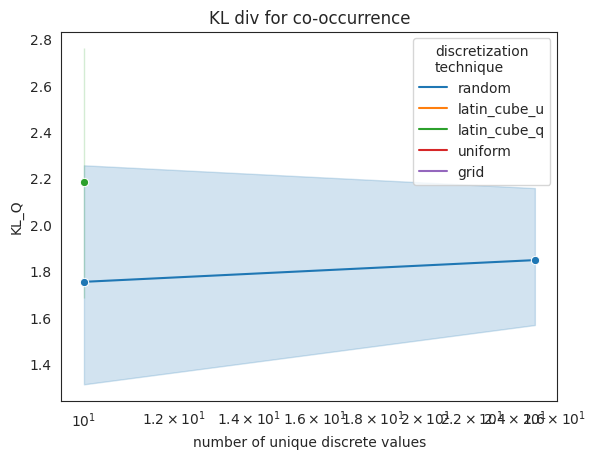

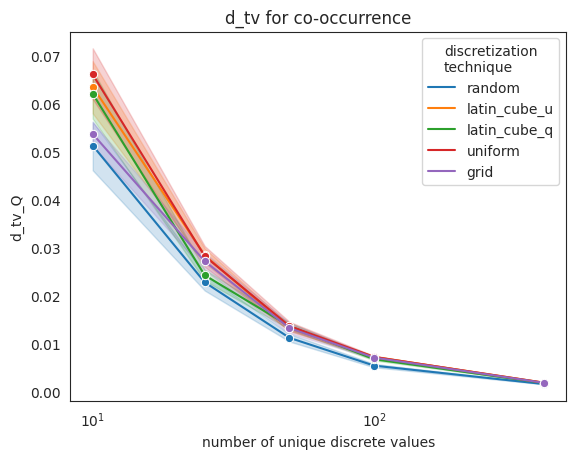

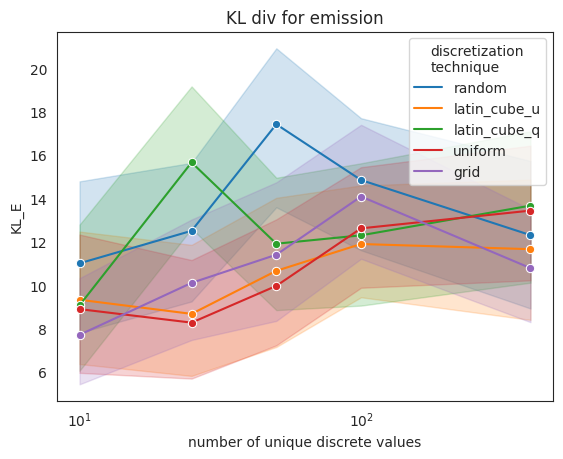

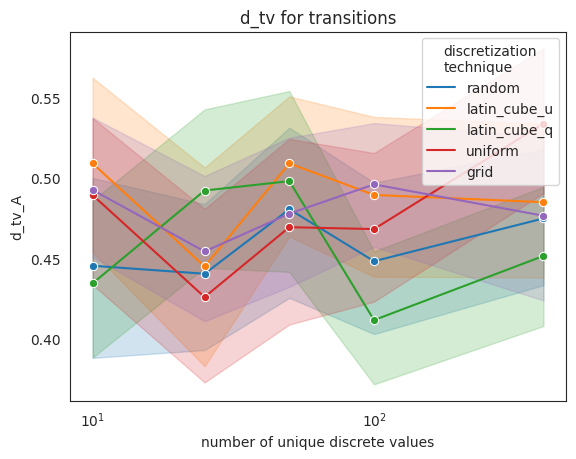

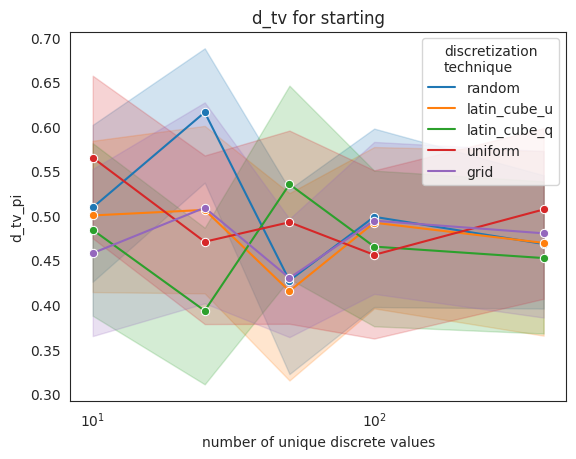

In [11]:
for col in titles.keys():
    sns.lineplot(results, x='n', y=col, hue='disc', marker='o')
    plt.title(titles[col])
    plt.xlabel('number of unique discrete values')
    plt.legend(title="discretization\ntechnique")
    plt.xscale('log')
    plt.savefig(f"{PROJECT_PATH}/theoretical_experiment/plots/2_{col}.png")
    plt.show()